# Section -1: Imports and Notebook Options

This section contains all the packages that were imported in order to make use of the methods implemented in this project.

## -1.1: Data Analysis Tools Imports
All imports that provide usage for the data analysis tools/methods used in this project.

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import re
import json

## -1.2: Stats Models Imports

All imports the provide usage for the statistical models that were implemented in this project.

In [2]:
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import Logit

## -1.3: Machine Learning Imports
All imports that provide usage for the machine learning algorithms/methods that were used in this project. 

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import mglearn.plots

## -1.4: Plotting Imports

All imports that provide usage for the plotting tools that were used in this project. 

In [4]:
import matplotlib.pyplot as plt
import mglearn.plots

## -1.5: Notebook Options

The cell below includes some of the various notebook settings that were used when completing this project. They can be changed to according to need. 

In [5]:
rs = 42 # random state used for all methods used in this project
replicates_size = 10000 # the number of null hypotheisis simulations done for all bootstrap hypothesis tests
pd.set_option('display.max_rows', 300) # max rows to be displayed from a pandas dataframe

# Section 0: Functions

This section contains an organized list of all functions that were used in this project, organized by the section in which they are used. Docstrings are provided explaining the usage of each function. 

## 0.1: Section 2 Functions
The cell below contains the definitions of all functions that were used in Section 2: Data Cleaning.

In [6]:
def get_borough_name(borough_code):
    '''Given the borough code of a NYC school, return the borough name as a string.'''
    if borough_code == 'K':
        return 'Brooklyn'
    elif borough_code == 'Q':
        return 'Queens'
    elif borough_code == 'M':
        return 'Manhattan'
    elif borough_code == 'X':
        return 'The Bronx'
    else:
        return 'Staten Island'

def separate_dbn_or_bn(dbn_or_bn_code):
    '''Given the DBN or BN code for a NYC school, performs the following:
    
    If given DBN: return a list containing the district, borough name, and name of the school.
    If given BN: return a list containing the borough name and name of the school. 
    
    District is retrned as an integer, while school and borough name are returned as strings.
    '''
    split_string = re.split('(X)|(K)|(Q)|(M)|(R)', dbn_or_bn_code)
    split_string = tuple(filter(None, split_string))
    if len(split_string) == 2:
        borough, number = split_string
        borough = get_borough_name(borough)
        return [borough, int(number)]
    else:
        district, borough, number = split_string
        borough = get_borough_name(borough)
        return [int(district), str(borough), int(number)]


def fill_name_and_district(borough, number, directory):
    '''Given the borough name and number of a NYC school, return a list containing its school
    name and district.
    
    The school name and district are returned by utilizing the 'directory' argument. This 
    arguement should be a dataframe of schools that provides the name, district, 
    school number and borough for each one. The function then uses this directory to match the
    provided borough and number to the school's name and district. 
    
    District is returned as an integer, while name is returned as a string.
    If no match can be found for the provided borough and number, [None, None] is returned.
    '''
    
    idx = (borough, number)
    if idx in directory.index:
        name = directory.loc[idx, 'school_name'][0]
        district = directory.loc[idx, 'district'][0]
        return [district, name]
    else:
        return [None, None]
    
def fix_ratings(rating):
    '''This function is meant to clean the improperly inputted or outdated ratings.
    
    NYCDOE school ratings used to include 'UPF' or 'U' (both stand for underperforming), which
    has since been replaced by 'UD' (underdeveloped). This function is meant to replace all
    'UPF' or 'U' ratings with 'UD' to account for this change. 
    '''
    if rating == 'UPF' or rating == 'U':
        return 'UD'
    else:
        return rating

## 0.2: Section 3 Functions

In [7]:
def make_numerical_ratings(rating):
    '''Converts the ratings given to NYC public schools to a numerical scale.
    
    The ratings and their conversions take the following form:
    UD - Underdeveloped --> returns 0 
    D - Developing --> returns 1
    P - Proficient --> returns 2
    WD - Well Developed --> returns 3
    
    All numerical ratings are returned as an integer. 
    '''
    if rating == 'UD':
        return 0
    elif rating == 'D':
        return 1
    elif rating == 'P':
        return 2
    else:
        return 3

def r_value_p_calc(size, x, y):
    '''Given a depdendent variable (y) and independent variable (x), determines the pearson 
    correlation coefficient (r) and returns the associated p value for that correlation.
    
    x --> independent variable data, must be 1-D.
    y --> dependent variable data, must be 1-D and same size as x.
    
    r is calculated using statsmodels' pearsonr() function. 
    p-value calculation is done by performing null hypothesis simulations to calculate 
    replicates of r and determining which fraction of those replicates is more or less than 
    the original r value. The number of null hypothesis simulationsis controlled by the 
    'size' argument.
    
    p-value is returned as a floating point number. 
    '''
    r_obs = pearsonr(x, y)[0]
    r_reps = np.empty(size)
    for i in range(size):
        perm = np.random.permutation(x)
        r_reps[i] = pearsonr(perm, y)[0]
    
    if r_obs < 0: 
        return np.sum(r_reps < r_obs) / size
    else:
        return np.sum(r_reps > r_obs) / size

def regression_replicates(size, x, y, d):
    inds = np.arange(len(x))
    
    replicates = np.empty((size, d+1))
        
    for i in range(size):
        choices = np.random.choice(inds, size = len(inds))
        new_x, new_y = x[choices], y[choices]
        results = np.polyfit(new_x, new_y, d)
        for j in range(0, d+1):
            replicates[i, j] = results[j]
        
        
    return replicates

def convert_to_binary(rating):
    '''Given a school quality review rating, return a 1 or 0 based on if that review is
    positive or negative. 

    If rating is UD (underdeveloped) or D (developing) --> return 0
    If rating is WD (well-developed) or P (proficient) --> return 1
    '''
    if rating == 'WD' or rating == 'P':
        return 1
    if rating == 'UD' or rating == 'D':
        return 0

## 0.3: Section 4 Functions

# Section 1: Introduction

This following project was completed in the hopes of answering the following question,
<br>
<br>


<center>
<b>Does the performance of public high schools in New York City have any dependence on the number of charter high schools in that same school district?</b>
</center>

As a former educator at a New York City public school, I have always been interested by the advent of charter schools, and have heard arguments regarding both their benefits and their drawbacks. While many of these charter schools in New York City have been able to produce results that are better than their public school counterparts, I have always been skeptical of how authentic these results are, and if they are achieved at the exspense of the rest of New York City's public schools. The work that follows was done in an attempt to resolve this dilemma. 

## 1.1 Abstract

Though charter schools have existed in this country for quite some time, their prevalence in recent years has increased significantly, especially in dense, urban areas such as New York City. Whether or not the creation of these charter schools has had a positive impact on the education systems in these areas has been hotly debated, with educators, politicians, and regular citizens on either side. Specifically, in New York City, proponents of charter schools say that the students they enroll perform better (on average) than students enrolled at their public school counterparts. For some, charter schools are the “long awaited solution” to New York City’s educational gap, as they have managed to produce results in school districts that are typically low performing.  However, those who oppose charter schools argue that, despite being privately owned, they are still publicly funded, and that this drains the already limited money and resources allocated to the New York City public schools. In addition, because of their typically large donor bases, many charter schools have recruitment networks in place, which critics say they use to “poach” higher performing students. In determining whether public high school performance in a district is dependent upon the number of charter school in that district, we can evaluate the legitimacy of some of these claims, and come up with possible explanations for why or why not that is the case. This report shows that while though there might be a correlation between these two variables, more data, and more likely more independent variables are needed in order to build more effective models that can better answer this question. 


## 1.2: Understanding the Data

The following subsection provides a summary of how to understand the data that is presented in future sections. More specifically, this section will provide preliminary explanations of New York City Department of Education (NYCDOE) school districts, school codes, and school ratings. 

### 1.2.1: NYCDOE School Districts

New York City consists of five boroughs containing a total of thirty-two different school districts. A map of these school districts can be seen in the picture below.

<img width=350 height=350 src="images/nyc_school_districts.jpg"/>

More specifically, each of New York City's boroughs contain the following school districts:

<table>
    <tr>
        <th>Borough</th>
        <th>Districts</th>
    </tr>
    <tr>
        <td>Manhattan</td>
        <td>1-6</td>
    </tr>
        <tr>
        <td>The Bronx</td>
        <td>7-12</td>
    </tr>
        <tr>
        <td>Brooklyn</td>
        <td>13-23, 32</td>
    </tr>
    <tr>
        <td>Queens</td>
        <td>24-30</td>
    </tr>
    <tr>
        <td>Staten Island</td>
        <td>31</td>
    </tr>
</table>


### 1.2.2: NYCDOE School Codes

There are two different types of school codes used by the NYCDOE, which are listed below:

<ul>
    <li>DBN Code - Stands for 'District, Borough, Number'</li>
    <li>BN Code - Stands for 'Borough, Number'</li>
</ul>

As is clear in the explanation above, the codes are simply acronyms explaining the information that they represent. Before moving onto an example, the boroughs represented in the two different types of school code have their own borough codes that should be reviewed. When differentiating boroughs, the NYCDOE uses the following letter codes:

<table>
    <tr>
        <th>Borough</th>
        <th>Borough Code</th>
    </tr>
    <tr>
        <td>Manhattan</td>
        <td>M</td>
    </tr>
        <tr>
        <td>The Bronx</td>
        <td>X</td>
    </tr>
        <tr>
        <td>Brooklyn</td>
        <td>K</td>
    </tr>
    <tr>
        <td>Queens</td>
        <td>Q</td>
    </tr>
    <tr>
        <td>Staten Island</td>
        <td>R</td>
    </tr>
</table>

Now for an example -- a school with DBN code 10X437 can be interpreted as follows, by breaking it up into its three components:
<ol>
    <li><b>District:</b> The school exists in district 10.</li>
    <li><b>Borough:</b> The school is located in the Bronx.</li>
    <li><b>Number:</b> The school's number is 437.</li>
</ol>

The BN code of a school contains only the school's borough code and school number, and is the exact same as the DBN minus the inclusion of the district number. For example, the BN code for a school with DBN code 10X437 is just X437. This means that school district number is not required in order to identify a single school and that, while the DBN code does provide more information, every school has a unique BN code that can be used to identify it. 


### 1.2.3: NYCDOE School Quality ReviewRatings

While there exist many assessment methods and metrics that the NYCDOE uses to a evaluate the performance of a school, the most rigorous by far is known as the quality review. A quality review of a school involves the school's superintendent and their staff performing a multiday observation of the school in which every classroom is visited at least once. Upon conclusion of these observations, the school is rated on a total of 10 different indicators and given an extensive writeup that is publicly available to parents, students, teachers etc. As such, positive ratings on a quality review are seen as crucial by school principals in order to attract both high level students and teachers. In addition, because these quality reviews are particuarly labor intensive, a school is given a quality review on average once every two or three years. <br>

The different indicators that each school is assessed on can be seen in the following excerpt from the NYCDOE <a href="https://infohub.nyced.org/docs/default-source/default-document-library/quality-review-rubric_18-19.pdf">2018-19 quality review rubric </a>:

<img width=500 height=500 src="images/quality_review_indicators.png"/>

The following chart lists the four different ratings that can be given to a school on each of the indicators:

<table>
    <tr>
        <th>Rating</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>WD</td>
        <td>Well-Developed</td>
    </tr>
        <tr>
        <td>P</td>
        <td>Proficient</td>
    </tr>
        <tr>
        <td>D</td>
        <td>Developing</td>
    </tr>
    <tr>
        <td>UD</td>
        <td>Underdeveloped</td>
    </tr>
</table>

Once a rating has been given on each of the indicators, an overall rating is given to the school using the same scale. No information could be found publicly that explained how the NYCDOE aggregates the indicator ratings into the single overall ranking. 

# Section 2: Cleaning Data

The work done in this section gives an in depth explanation of all the data cleaning steps that were required in order to begin analysis. It is recommended that Section 1.2 is read and understood in order to fully understand the purpose and meaning of all data cleaning steps. 

## 2.1: Cleaning Charter School Data

The goal in compiling the charter school data was to create a dataframe containing the number of charters schools in a district for each year. While an extensive search did not result in finding this data exactly, <a href="http://www.p12.nysed.gov/psc/csdirectory/CSLaunchPage.html">the New York State Education website</a> did offer a directory of all charter schools that were active in New York City as of the 2018 school year. This information was available for download as an <a href="Data/nyc_charter_school_list.xlsx"> excel spreadsheet </a>, which is read into a dataframe in the cell below.

In [9]:
# summary: read in excel file as dataframe and print out column info. 
charter_list = pd.read_excel('Data/nyc_charter_school_list.xlsx') 
charter_list.head();
charter_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 14 columns):
DBN                           236 non-null object
Bedscode                      292 non-null int64
School Name                   292 non-null object
School District               292 non-null object
NYC                           292 non-null object
CSD                           234 non-null float64
Network Name                  153 non-null object
Network Type                  119 non-null object
Conversion                    292 non-null object
Unionized                     292 non-null object
2018-19 Years of Operation    292 non-null int64
Grades                        292 non-null object
Charter End Date              292 non-null datetime64[ns]
Authorizer                    292 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(10)
memory usage: 32.0+ KB


As is clear in the information provided above, this dataset contains many columns, some of which are not relevant in order to evaluate the question being asked. The columns that are relevant, along with the information that they contain, are listed as follows:

<ul>
    <li><b>DBN</b> -  the DBN code for the charter school.</li>
    <li><b>School Name</b> - the full text name of the charter school.</li>
    <li><b>NYC</b> - whether or not the school is located in New York City.</li>
    <li><b>CSD</b> - The charter school district that the charter school is located in.</li>
    <li><b>2018-19 Years of Operation</b> - How many years the charter school has been open at the start of the 2018 school year.</li>
</ul>

These columns are extracted in the cell below.


In [10]:
# summary: extract the relevant columns from the charter school dataframe. 
col_list = ['DBN', 'School Name', 'NYC', 'CSD', 'Grades', '2018-19 Years of Operation']
charter_list = charter_list[col_list]
charter_list.head()

,DBN,School Name,NYC,CSD,Grades,2018-19 Years of Operation
0,84X491,Academic Leadership Charter School,Yes,7.0,"0K,01,02,03,04,05,06,07,08",10
1,NaN,Academy Charter School,No,NaN,"0K,01,02,03,04,05,06,07,08,09,10,11",10
2,NaN,Academy Charter School - Uniondale (The),No,NaN,"0K,01,02",1
3,84Q359,Academy of the City Charter School,Yes,30.0,"0K,01,02,03,04,05",8
4,84K774,Achievement First Apollo Charter School,Yes,19.0,"0K,01,02,03,04,05,06,07,08,09",9


Because the scope of this project only included New York City schools, the next step in cleaning the charter school data is to remove all schools that were not located in NYC. Since the <b>NYC</b> column reads 'Yes' if the school is in NYC, all non-NYC schools can be removed by a simple filtering of this column. This is done in the cell below.

In [11]:
# summary: remove all schools from the dataframe that are not located in NYC.
charter_list = charter_list[charter_list['NYC'] == 'Yes'].reset_index(drop = True)
charter_list = charter_list.drop('NYC', axis = 1)
charter_list.head()

,DBN,School Name,CSD,Grades,2018-19 Years of Operation
0,84X491,Academic Leadership Charter School,7.0,"0K,01,02,03,04,05,06,07,08",10
1,84Q359,Academy of the City Charter School,30.0,"0K,01,02,03,04,05",8
2,84K774,Achievement First Apollo Charter School,19.0,"0K,01,02,03,04,05,06,07,08,09",9
3,84K680,Achievement First Aspire Charter School,19.0,"0K,01,02,03,04,05,06",6
4,84K626,Achievement First Brownsville Charter School,23.0,"0K,01,02,03,04,05,06,07,08,09,10,11",11


Now that the dataframe only included NYC charter schools, each school's district also had to be identified. This could be done by breaking apart the DBN code located in the <b>DBN</b> column. The function `separate_dbn_or_bn()` was created in order to serve this purpose. It is used in conjunction with the apply method below to create three new columns: <b>district</b>, <b>borough</b>, and <b>number</b>.

In [12]:
# summary: separate DBN code into its three separate components (columns).
charter_list[['district', 'borough', 'number']] = charter_list.apply(
    lambda row: pd.Series(separate_dbn_or_bn(row['DBN'])), axis = 1)

charter_list = charter_list.drop('DBN', axis = 1)
charter_list.head()

,School Name,CSD,Grades,2018-19 Years of Operation,district,borough,number
0,Academic Leadership Charter School,7.0,"0K,01,02,03,04,05,06,07,08",10,84,The Bronx,491
1,Academy of the City Charter School,30.0,"0K,01,02,03,04,05",8,84,Queens,359
2,Achievement First Apollo Charter School,19.0,"0K,01,02,03,04,05,06,07,08,09",9,84,Brooklyn,774
3,Achievement First Aspire Charter School,19.0,"0K,01,02,03,04,05,06",6,84,Brooklyn,680
4,Achievement First Brownsville Charter School,23.0,"0K,01,02,03,04,05,06,07,08,09,10,11",11,84,Brooklyn,626


Now that the dataframe contains three new columns containing the district, borough, and number of each school, the <b>DBN</b> column becomes obsolete, and was removed. A summary of the new dataframe is given in the cell below.

In [13]:
charter_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 7 columns):
School Name                   236 non-null object
CSD                           234 non-null float64
Grades                        236 non-null object
2018-19 Years of Operation    236 non-null int64
district                      236 non-null int64
borough                       236 non-null object
number                        236 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 13.0+ KB


According to the information above, this cleaner version of the dataframe now only contains 236 charter schools, as opposed to the original 292. <br>

However, the header of the data frame reveals a new problem: in the district column, all of the schools are located in Distirct 84. Since the NYC public school districts are only supposed to go up to 32, this cannot be the case.  This dilemma can be seen in more detail in the cell below. 

In [14]:
charter_list['district'].value_counts()

84    236
Name: district, dtype: int64

After doing some research, it turns out that all charter schools in NYC are given district number 84 in order to differentiate them from the public schools. However, this same research also revealed that the charter school district number (dataframe column <b>CSD</b>) is actually just the geographic school district that the school is located in. As such, the next step is to replace the <b>district</b> column with the <b>CSD</b> column, as those numbers are the actual public school districts that the charter schools are located in. However, two schools had missing entires for the <b>CSD</b> column, as can be seen in the cell below.

In [15]:
# summary: determine all schools that have missing entries in the CSD column. 
nan_rows = charter_list[charter_list['CSD'].isnull()]
nan_rows

,School Name,CSD,Grades,2018-19 Years of Operation,district,borough,number
122,Key Collegiate Charter School,NaN,"04,05",1,84,Brooklyn,912
137,Lois and Richard Nicotra Early College Charter...,NaN,"08,09,SE",1,84,Staten Island,70


The two cells listed above had missing entries in for their charter school district, but were identify online. The two school's correct charter school district in inputted in the cell below:

In [16]:
# summary: fill in missing charter school districts for two schools. 
charter_list.at[122, 'CSD'] = 23.0
charter_list.at[137, 'CSD'] = 31.0
charter_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 7 columns):
School Name                   236 non-null object
CSD                           236 non-null float64
Grades                        236 non-null object
2018-19 Years of Operation    236 non-null int64
district                      236 non-null int64
borough                       236 non-null object
number                        236 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 13.0+ KB


As can be seen in the above summary, the <b>CSD</b> column now has 236 non-null values, as opposed to only 234.<br>

The next step is to replace the information in the <b>district</b> column with the information in the <b>CSD</b> column. This is done below:

In [17]:
# summary: replace information in district column with information from CSD column. 
charter_list['district'] = charter_list['CSD'].astype('int64')
charter_list = charter_list.drop('CSD', axis = 1)
charter_list.head()

,School Name,Grades,2018-19 Years of Operation,district,borough,number
0,Academic Leadership Charter School,"0K,01,02,03,04,05,06,07,08",10,7,The Bronx,491
1,Academy of the City Charter School,"0K,01,02,03,04,05",8,30,Queens,359
2,Achievement First Apollo Charter School,"0K,01,02,03,04,05,06,07,08,09",9,19,Brooklyn,774
3,Achievement First Aspire Charter School,"0K,01,02,03,04,05,06",6,19,Brooklyn,680
4,Achievement First Brownsville Charter School,"0K,01,02,03,04,05,06,07,08,09,10,11",11,23,Brooklyn,626


As is clear in the dataframe header shown above, each school's correct geographic school district is now given in the <b>district</b> column. <br>

However, having just the correct district for each charter school is not sufficient to answer the question at hand. In addition to knowing the district each charter school was located in, we must also know how many years each charter school was in that district. The first step in doing this is to create a new column that contains the year in which the charter school was opened. This is done using the information in the <b>2018-19 Years of Operation</b> column, and simply subtracting that number from 2019 (the current school year):

In [18]:
# summary: create a new column, 'opening_year' that gives the year each school opened. 
charter_list['opening_year'] = 2019 - charter_list['2018-19 Years of Operation']
# only go up to 2017, since thats the last year for which public school ratings are publically available:
charter_list = charter_list[charter_list['opening_year'] <= 2017]
charter_list = charter_list.drop('2018-19 Years of Operation', axis = 1)
charter_list.head()

,School Name,Grades,district,borough,number,opening_year
0,Academic Leadership Charter School,"0K,01,02,03,04,05,06,07,08",7,The Bronx,491,2009
1,Academy of the City Charter School,"0K,01,02,03,04,05",30,Queens,359,2011
2,Achievement First Apollo Charter School,"0K,01,02,03,04,05,06,07,08,09",19,Brooklyn,774,2010
3,Achievement First Aspire Charter School,"0K,01,02,03,04,05,06",19,Brooklyn,680,2013
4,Achievement First Brownsville Charter School,"0K,01,02,03,04,05,06,07,08,09,10,11",23,Brooklyn,626,2008


As can be seen in the dataframe headed above, the <b>2018-19 Years in Operation</b> column has been replaced by <b>opening_year</b>, which simply lists the year that the charter school opened. <br>

In the cell below, the dataframe is reorganized.

In [19]:
# summary: reorder the columns in the dataframe. 
col_list = ['borough', 'district', 'number', 'School Name', 'Grades', 'opening_year']
charter_list = charter_list[col_list]
charter_list.head()

,borough,district,number,School Name,Grades,opening_year
0,The Bronx,7,491,Academic Leadership Charter School,"0K,01,02,03,04,05,06,07,08",2009
1,Queens,30,359,Academy of the City Charter School,"0K,01,02,03,04,05",2011
2,Brooklyn,19,774,Achievement First Apollo Charter School,"0K,01,02,03,04,05,06,07,08,09",2010
3,Brooklyn,19,680,Achievement First Aspire Charter School,"0K,01,02,03,04,05,06",2013
4,Brooklyn,23,626,Achievement First Brownsville Charter School,"0K,01,02,03,04,05,06,07,08,09,10,11",2008


However, in order to see if the number of charter schools has had an impact on public school performance over the years, the information present in the dataframe above is still not enough. Instead of knowing when each charter school was opened, a complete list giving the number of charter schools in each district for all years is required. The steps taken to complete this are shown below:

In [20]:
# summary: create a multi-level index on columns, [borough, district, opening_year] and sort it.
charter_list = charter_list.set_index(['borough', 'district', 'opening_year']).sort_index()
charter_list.loc[('Brooklyn', 13, 2000)]

,,,number,School Name,Grades
borough,district,opening_year,,,
Brooklyn,13,2000,702,Community Partnership Charter School,"PK,0K,01,02,03,04,05,06,07,08"


In [21]:
# summary: create an empty dictionary to count number of each schools by iterating through the dataframe
keys = [(i, j) for i in range(1, 33) for j in range(1999, 2018)]
school_counter = {key:0 for key in keys}
for index, row in charter_list.iterrows():
    b, d, y = index
    school_counter[(d, y)] += 1

In [22]:
# summary: turn the school counter dictionary into a dataframe containing the number of schools in each district
# per year. 
new_school_counter = {'district' : [], 'year' : [], 'num_charters' : []}
for key, value in school_counter.items():
    district, year = key
    new_school_counter['district'].append(district)
    new_school_counter['year'].append(year)
    new_school_counter['num_charters'].append(value)
    
num_charters_df = pd.DataFrame(new_school_counter).set_index('district').sort_index()
num_charters_df['num_charters'] = num_charters_df['num_charters'].groupby('district').cumsum()
num_charters_df = num_charters_df[num_charters_df['year'] >= 2005]
num_charters_df = num_charters_df.reset_index().set_index(['district', 'year'])
num_charters_df.head(15)

num_charters
district year              
1        2005             2
         2006             2
         2007             2
         2008             2
         2009             2
         2010             2
         2011             2
         2012             3
         2013             4
         2014             4
         2015             4
         2016             4
         2017             4
2        2005             1
         2006             1

By using the `charter_list` dataframe, the new `num_charters_df` dataframe shown above now holds the number of charter schools in each school district for all years from 2005-2018. This by far the most complicated of the data cleaning steps, but concludes the cleaning of the charter school data. 

## 2.2: Cleaning Public School Data

This subsection shows all steps that were required in order to clean the public school data used by this project. The goal in cleaning this data was to acquire the most common quality review rating that was given to each school district every year. All data that was used in this subsection can be found on <a href="https://opendata.cityofnewyork.us/">NYC's Open Data website</a>. <br> 

NYC Open Data provides access to their datasets via the Socrata Open Data API (SODA). Documentation for how to use this API can be found <a href="https://dev.socrata.com/">here</a>. The API provides query functionality through a language they refer to as "Socrata Query Language" (SoSQL), which, as the name might suggest borrows heavily from the conventions used by SQL.

The primary dataset that is used below provides <a href="https://data.cityofnewyork.us/Education/2005-2017-School-Quality-Review-Ratings/9n9z-hh9p"> a list of all schools that have received quality reviews from 2005-2017 along with their rankings </a>. It is imported using the API and converted into a dataframe in the cell below:


In [23]:
# summary: Import public school quality review rankings and convert into a dataframe. 
row_limit = '10000'
cols = 'bn,school_year,overall_rating' 
SoQL_query = '&$select=' + cols
r = rq.get('https://data.cityofnewyork.us/resource/9n9z-hh9p.json?$limit=' + row_limit + SoQL_query)
public_school_ratings = pd.DataFrame(r.json())

#public_school_ratings['school_year'] = public_school_ratings['school_year'].str.slice(stop = 4).astype(int)

print('Shape of the dataset: {}'.format(public_school_ratings.shape))
public_school_ratings.head()

Shape of the dataset: (8064, 3)


,bn,overall_rating,school_year
0,M307,P,2005-06-01T00:00:00.000
1,M459,P,2005-06-01T00:00:00.000
2,M560,WD,2005-06-01T00:00:00.000
3,M294,WD,2005-06-01T00:00:00.000
4,M299,P,2005-06-01T00:00:00.000


The cols variable in the cell above gives a list of all the columns that were included in the SoSQL query. While the dataset did include rankings for all indicators included on the quality review rubric (see Section 1.2.3), only the overall ranking was taken. 

Before performing any data cleaning steps, the cell below uses the `.info()` to get a summary of the newly imported dataset:

In [24]:
public_school_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8064 entries, 0 to 8063
Data columns (total 3 columns):
bn                8064 non-null object
overall_rating    8064 non-null object
school_year       4829 non-null object
dtypes: object(3)
memory usage: 189.1+ KB


Unfortunately, the <b>school_year</b> column includes only 4,829 non-null values, out of about 8,064. Upon closer inspection, these missing values were all listed as `NaN`. In addition, many of the entries in the <b>overall_rating</b> column were simply listed as 'No Data':

In [25]:
public_school_ratings['overall_rating'].value_counts()

P          2995
No Data    2236
WD         1767
D           690
U           155
UPF         132
UD           34
DYO          30
O            24
P             1
Name: overall_rating, dtype: int64

Even if a row did contain a actual rating, it becomes useless unless the year in which it was given is also known. For this reason, all rows containing missing values in the <b>school_year</b> column had to be removed. This is done in the cell below:

In [26]:
public_school_ratings = public_school_ratings.dropna(axis = 0)
public_school_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4829 entries, 0 to 4831
Data columns (total 3 columns):
bn                4829 non-null object
overall_rating    4829 non-null object
school_year       4829 non-null object
dtypes: object(3)
memory usage: 150.9+ KB


As can be seen in the cell below, each column now contains the same number of non null values, which is the same number as the total number of entries. In addition, by removing the NaN values from the <b>school_year</b> column, all 'No Data' entries from the rating column were removed as well:

In [27]:
public_school_ratings['overall_rating'].value_counts()

P      2431
WD     1645
D       385
U       155
UPF     132
DYO      30
UD       26
O        24
P         1
Name: overall_rating, dtype: int64

While removing all the missing data is a crucial step in cleaning this dataset, some exploration revealed that the only ratings that remained were from quality reviews that occured from the years 2005-2011. Evidence for this is seen in the cell below:

In [28]:
public_school_ratings['school_year'] = public_school_ratings['school_year'].str.slice(stop = 4).astype(int)
print('Number of ratings from quality reviews taking place after 2011: ')
print(public_school_ratings[public_school_ratings['school_year'] > 2011].shape[0])

Number of ratings from quality reviews taking place after 2011: 
0


Having ratings only from the years 2005-2011 is the first of many considerations that need to be taken into account when reviewing the future analysis. As of the time of this writing, the dataset on NYC Open Data has not been updated to include the more current missing ratings. The dataframe in its current form exists as follows:

In [29]:
print('Shape of the dataframe: {}'.format(public_school_ratings.shape))
public_school_ratings.head()

Shape of the dataframe: (4829, 3)


,bn,overall_rating,school_year
0,M307,P,2005
1,M459,P,2005
2,M560,WD,2005
3,M294,WD,2005
4,M299,P,2005


As is clearly seen in the dataframe header above, each entry represents a school and includes the rating it received on the quality review as well as the year in which the quality review was given. However, the dataframe in its current form presents another problem: the code that is given to identify the school is the school's BN code (given by the <b>bn</b> column), as opposed to its DBN code (see Section 1.2.2). While the BN code is enough to identify a school, it does not incldue its district. Since this project requires looking at the most common rating for public schools by district, this is a crucial piece of missing information. <br>

In other words, in order to determine the district of each school, additional data was required. Fortunately,  <a href="https://opendata.cityofnewyork.us/">NYC Open Data</a> also had access to school directory datasets that included both the school names, along with their DBN codes. Because they included the DBN codes, these datasets gave each school's district. In the cell below, a dataset consisting of <a href="https://data.cityofnewyork.us/Education/2018-DOE-High-School-Directory/vw9i-7mzq">NYC's 2018 high school directory</a> is imported and converted into a dataframe.

In [30]:
# summary: import the 2018 high school directory and convert it into a dataframe. 
SoQL_query = '&$select=dbn,school_name AS Name'
r = rq.get('https://data.cityofnewyork.us/resource/h7rb-945c.json?' + SoQL_query)
hs_directory_2018 = pd.DataFrame(r.json())
hs_directory_2018.head()

,Name,dbn
0,Felisa Rincon de Gautier Institute for Law and...,08X519
1,Urban Assembly High School of Music and Art,13K350
2,Queens Gateway to Health Sciences Secondary Sc...,28Q680
3,Women's Academy of Excellence,08X282
4,World Journalism Preparatory: A College Board ...,25Q285


The dataframe shown above provides a simply list of all schools that were active at the start of the 2018 school year, along with their respective DBN codes (given by the <b>dbn</b> column). In the cell below, these DBN codes are broken up into their respective components and given columns of their own, using the `separate_dbn_or_bn` function: 

In [31]:
# summary: separate the DBN codes of the hs directory into three separate columns: district, borough, and number. 
hs_directory_2018[['district', 'borough', 'number']] = hs_directory_2018.apply(
    lambda row: pd.Series(separate_dbn_or_bn(row['dbn'])), axis = 1)

hs_directory_2018 = hs_directory_2018.drop('dbn', axis = 1)
print('Shape of the dataset: {}'.format(hs_directory_2018.shape))
hs_directory_2018.head()

Shape of the dataset: (435, 4)


,Name,district,borough,number
0,Felisa Rincon de Gautier Institute for Law and...,8,The Bronx,519
1,Urban Assembly High School of Music and Art,13,Brooklyn,350
2,Queens Gateway to Health Sciences Secondary Sc...,28,Queens,680
3,Women's Academy of Excellence,8,The Bronx,282
4,World Journalism Preparatory: A College Board ...,25,Queens,285


As can be seen in the dataframe header shown above, the `hs_directory_2018` dataframe now includes three additional columns: <b>district</b>, <b>borough</b>, and <b>number</b>. However, the schools included in the `public_school_ratings` dataframe consist of more than just high schools. However, NYC Open Data also has access to a dataset that consists of all <a href="https://data.cityofnewyork.us/Education/2018-DOE-Middle-School-Directory/6kcb-9g8d">NYC <i>middle</i> schools that were operational at the start of the 2018 school year.</a>  In the cells below, this dataset is imported and converted into a dataset. 

In [32]:
# summary: import the 2018 middle school directory and convert it into a dataframe.
SoQL_query = '&$select=schooldbn,printedschoolname AS Name'
r = rq.get('https://data.cityofnewyork.us/resource/6kcb-9g8d.json?' + SoQL_query)
ms_directory_2018 = pd.DataFrame(r.json())
ms_directory_2018.head()

,Name,schooldbn
0,Park Terrace (P.S. 18),06M018
1,I.S. 52 (Inwood Intermediate School 52),06M052
2,Eleanor Roosevelt Intermediate School (I.S. 143),06M143
3,Hudson Cliffs School (P.S./I.S. 187),06M187
4,Hamilton Grange Middle School,06M209


Once again, the `separate_dbn_or_bn()` function is used below to separate the DBN codes seen above into three separate columns: <b>district</b>, <b>borough</b>, and <b>number</b>.   

In [33]:
# summary: separate the DBN codes of the ms directory into three separate columns: district, borough, and number. 
ms_directory_2018[['district', 'borough', 'number']] = ms_directory_2018.apply(
    lambda row: pd.Series(separate_dbn_or_bn(row['schooldbn'])), axis = 1)

ms_directory_2018 = ms_directory_2018.drop('schooldbn', axis = 1)
print('Shape of the dataset: {}'.format(ms_directory_2018.shape))
ms_directory_2018.head()

Shape of the dataset: (484, 4)


,Name,district,borough,number
0,Park Terrace (P.S. 18),6,Manhattan,18
1,I.S. 52 (Inwood Intermediate School 52),6,Manhattan,52
2,Eleanor Roosevelt Intermediate School (I.S. 143),6,Manhattan,143
3,Hudson Cliffs School (P.S./I.S. 187),6,Manhattan,187
4,Hamilton Grange Middle School,6,Manhattan,209


To summarize, two separate dataframes (`ms_directory_2018` and `hs_directory_2018`) now contain the names, district, boroughs, and numbers for all NYC middle schools and high schools that were operational at the start of the 2018 school year. These two datasets are appended together, reorganized, and then reindexed in the following cell.

In [34]:
# summary: append together the middle and high school directories, reorganize, and reindex them. 
school_directory_2018 = hs_directory_2018.append(ms_directory_2018)
school_directory_2018.columns = ['school_name', 'district', 'borough', 'number']
school_directory_2018 = school_directory_2018.set_index(['borough', 'number']).sort_index()
print('Shape of the dataset: {}'.format(school_directory_2018.shape))
school_directory_2018.head()

Shape of the dataset: (919, 2)


school_name  district
borough  number                                              
Brooklyn 2             Parkside Preparatory Academy        17
         8              Robert Fulton (P.S./M.S. 8)        13
         14                  Shell Bank (J.H.S. 14)        22
         30      Mary White Ovington (P.S./I.S. 30)        20
         35        Stephen Decatur Middle School 35        16

The `school_directory_2018` dataframe now contains a list of all middle and high schools that were open as of the 2018 school year, which consists of 919 schools (484 middle schools, and 435 high schools). The goal in creating this dataframe was to provide a way to fill in the missing districts from the schools listed in the `public_school_ratings` dataframe. However, before doing so, the BN codes provided in the public school directory are broken up into their separate components using the `separate_dbn_or_bn()` function once again. This is done in the cell below:

In [35]:
public_school_ratings = public_school_ratings.drop(75).reset_index(drop = True) # Remove row with missing entry.
public_school_ratings['bn'] = public_school_ratings['bn'].str.upper()

public_school_ratings[['borough', 'number']] = public_school_ratings.apply(  
    lambda row: pd.Series(separate_dbn_or_bn(row['bn'])), axis = 1)

public_school_ratings.drop('bn', axis = 1)
print('Shape of the dataset: {}'.format(public_school_ratings.shape))
public_school_ratings.head()

Shape of the dataset: (4828, 5)


,bn,overall_rating,school_year,borough,number
0,M307,P,2005,Manhattan,307
1,M459,P,2005,Manhattan,459
2,M560,WD,2005,Manhattan,560
3,M294,WD,2005,Manhattan,294
4,M299,P,2005,Manhattan,299


Now that `public_school_ratings` directory has had its BN codes separated into a <b>borough</b> and <b>number</b> column, the `school_directroy_2018` dataframe can be used to fill in the missing districts for each school. This is done below, using the `fill_name_and_district()` function in conjunction with an the `.apply()` method:

In [36]:
public_school_ratings[['district', 'school_name']] = public_school_ratings.apply(
    lambda row: pd.Series(fill_name_and_district(row['borough'], row['number'], school_directory_2018)), axis = 1)

# remove all schools that were not in the school directory:
public_school_ratings = public_school_ratings.dropna(subset=['district']).reset_index(drop = True)
print('Shape of the dataset: {}'.format(public_school_ratings.shape))
public_school_ratings.head()

Shape of the dataset: (2246, 7)


,bn,overall_rating,school_year,borough,number,district,school_name
0,M307,P,2005,Manhattan,307,3.0,"Urban Assembly School for Media Studies, The"
1,M459,P,2005,Manhattan,459,2.0,Manhattan International High School
2,M294,WD,2005,Manhattan,294,2.0,Essex Street Academy
3,M299,P,2005,Manhattan,299,3.0,The Maxine Greene High School for Imaginative ...
4,M407,WD,2005,Manhattan,407,2.0,Institute for Collaborative Education (ICE)


As is clear in the dataframe header above, the `public_school_ratings` directory now includes the district and name for every school. Unfortunately, about half of the entires that were included in the dataset could not be matched to a name or district (the number of rows in the dataset decreased from 4,828 to 2,246). This is likely because the `school_directory_2018` dataframe does not include information for the city's elementary schools, which make up about half of all of NYC's public schools. An extensive search was done to try and find a comprehensive list of these schools (similar to the ones NYC Open Data had for middle and high schools), but none could be found. This is another consideration that needs to be taken into account regarding future analysis. <br>

A sample of this dataset is shown in the cell below, and shows only the quality reviews that were given to district 1 schools. 

In [37]:
d1 = public_school_ratings[public_school_ratings['district'] == 1.0]
d1.head()

,bn,overall_rating,school_year,borough,number,district,school_name
8,M696,WD,2005,Manhattan,696,1.0,Bard High School Early College
250,M034,P,2006,Manhattan,34,1.0,Franklin Delano Roosevelt (P.S. 34)
253,M839,WD,2006,Manhattan,839,1.0,Tompkins Square Middle School
259,M140,P,2006,Manhattan,140,1.0,The Nathan Straus Preparatory School (P.S. 140)
262,M184,P,2006,Manhattan,184,1.0,Shuang Wen School (P.S. 184)


While the <b>overall_rating</b> column has been cleared of all of its 'No Data' entries, it still contains a number of ratings that were not included on the NYCDOE <a href="https://infohub.nyced.org/docs/default-source/default-document-library/quality-review-rubric_18-19.pdf">2018-19 quality review rubric </a> (see section 1.2.3). The ratings, `UPF`, `DYO`, `U`, and `O` are all not listed as possible ratings:

In [38]:
public_school_ratings['overall_rating'].value_counts()

P      1166
WD      739
D       176
U        63
UPF      60
DYO      23
UD       11
O         8
Name: overall_rating, dtype: int64

After some research, it was discovered that the `U` (unsatisfactory) and `UPF` (underperforming) ratings are outdated versions of what has now been replaced by the `UD` (underdeveloped) rating. No such information could be found regarding the `DYO` and `O` ratings. For this reason, the following cell performs two data cleaning steps:
<ul>
    <li>Removes all rows with DYO or O ratings</li>
    <li>Replaces all UPF or U ratings with a UD rating.</li>
</ul>

The second of these steps is performed by use of the `fix_ratings` function in conjunction with the `.map()` method.

In [39]:
public_school_ratings = public_school_ratings[public_school_ratings['overall_rating'] != 'DYO'].reset_index(drop=True)
public_school_ratings = public_school_ratings[public_school_ratings['overall_rating'] != 'O'].reset_index(drop=True)
public_school_ratings['overall_rating'] = public_school_ratings['overall_rating'].map(fix_ratings)
public_school_ratings['overall_rating'].value_counts()

P     1166
WD     739
D      176
UD     134
Name: overall_rating, dtype: int64

As is made clear in the `.value_counts()` printout above, the only ratings that are now included in the dataframe are those that actually appear on the NYCDOE quality review rubric. </br>

The final step in cleaning this dataset is to now determine the most common rating given to the public schools in a district from the years 2005-2011. This is done in the cell below:

In [40]:
most_common_ratings = public_school_ratings.groupby(['district', 'school_year'])['overall_rating'].apply(
    lambda x: x.value_counts().index[0]).reset_index()
num_ratings = public_school_ratings.groupby(['district', 'school_year'])['bn'].count().values


most_common_ratings.columns = ['district', 'year', 'most_common_rating']
most_common_ratings['num_ratings'] = num_ratings
most_common_ratings = most_common_ratings.set_index(['district', 'year'])

most_common_ratings.head()

most_common_rating  num_ratings
district year                                
1.0      2005                 WD            1
         2006                  P           12
         2007                  P           13
         2008                  P            3
         2009                 WD            8

With the creation of the `most_common_ratings` dataset, the cleaning of the public school data is complete. This dataframe now contains an organized list of the most common quality review rating in each district from the yers 2005-2011. In addition, the number of ratings that were given that year is district is provided by the <b>num_ratings</b> column.

## 2.3: Combining the Datasets

The last step in the data cleaning process is to combine the public school and charter school data into one dataset. More specifically, the goal is to combine the `most_common_ratings` dataframe with the `num_charters` dataframe, which will a new dataframe that contains the most common rating public school rating, as well as the number of charter schools in each district from the years 2005-2011. As a reminder of the contents of the `most_common_ratings` and `num_charters_df` dataframe, the header of each is printed out below.

In [41]:
df1 = num_charters_df.reset_index()
print('Shape of the dataframe: {}'.format(df1.shape))
df1.head()

Shape of the dataframe: (416, 3)


,district,year,num_charters
0,1,2005,2
1,1,2006,2
2,1,2007,2
3,1,2008,2
4,1,2009,2


In [42]:
df2 = most_common_ratings.reset_index()
print('Shape of the dataframe: {}'.format(df2.shape))
df2.head(8)

Shape of the dataframe: (218, 4)


,district,year,most_common_rating,num_ratings
0,1.0,2005,WD,1
1,1.0,2006,P,12
2,1.0,2007,P,13
3,1.0,2008,P,3
4,1.0,2009,WD,8
5,1.0,2010,D,7
6,1.0,2011,D,3
7,2.0,2005,WD,10


Note that in the cells above, the `most_common_rating` and `num_charters_df` dataframe are flattened and defined as `df1` and `df2`. The purpose of this is to prepare for the datasets to be merged. The merging of these two datasets in performed in the cell below:

In [43]:
df_merged = pd.merge(df1, df2, on=['district', 'year'])
print('Shape of the dataframe: {}'.format(df_merged.shape))
df_merged.head(8)

Shape of the dataframe: (218, 5)


,district,year,num_charters,most_common_rating,num_ratings
0,1,2005,2,WD,1
1,1,2006,2,P,12
2,1,2007,2,P,13
3,1,2008,2,P,3
4,1,2009,2,WD,8
5,1,2010,2,D,7
6,1,2011,2,D,3
7,2,2005,1,WD,10


Because the `most_common_ratings` dataframe only had entries between the years 2005-2011, many of the entries from the `num_charters_df` rating were lost by the merge. The result is a dataframe containing 218 entries. However, the actual number of entries should be:<br><br>
<center>
$32 \text{ districts } \cdot 7 \text{ years} = 224 \text{ entries}$
</center>
<br>
The reason for the missing entries is most likely due to the O or DYO ratings that were removed, as these scores were not interpretable. <br>

While this project was devised in the hopes of seeing if the number of charter schools in a district had any impact on the most common public school rating in that same district, it is more than plausible that the number of charters is not the only independent variable affecting the most common rating. As such, the final data cleaning step shown below creates two new columns, <b>num_public</b> and <b>pub_chtr_diff</b> which provide the number of public schools in a district and the difference between the number of public school and charter schools in a district, respectively. These values represent new independent variables that could be important predictors, and are still related to the number of charter schools in a district. 

In [44]:
# using 2018 directory for number of public schools for all years (maybe a bad idea?)
num_public_schools = school_directory_2018.groupby(['district']).count() 
num_public_schools = num_public_schools.reset_index()
num_public_schools.columns = ['district', 'num_public']
df_final = pd.merge(df_merged, num_public_schools, on='district')
df_final['pub_chtr_diff'] = df_final['num_public'] - df_final['num_charters']
df_final.head()

,district,year,num_charters,most_common_rating,num_ratings,num_public,pub_chtr_diff
0,1,2005,2,WD,1,16,14
1,1,2006,2,P,12,16,14
2,1,2007,2,P,13,16,14
3,1,2008,2,P,3,16,14
4,1,2009,2,WD,8,16,14


As is clear in the code above, the number of public schools (given by the <b>num_public</b> column) was determined by using the `school_directory_2018` directory, which lists only the schools that were active during the 2018 school year. The assumption being made here is that the number of public schools in a district does not vary much over the years, and that the number of public schools in a school district in 2018 is probably close to what it has been in preceding years. However, this could be an incorrect assumption, and is yet another consideration that needs to be taken into account regarding the upcoming analysis. An attempt was made to find a list of all public schools from the years 2005-2011, but could not be found on NYC's Open Data website, or anywhere else. <br>

The <b>pub_chtr_diff</b> column was created simply by subtracting the number from the <b>num_charters</b> column from the number in the <b>num_public</b> column. <br>

The dataset seen above represents the final, cleaned dataset that is used in future analysis.  

# Section 3: Exploratory Data Analysis (EDA)

The steps in this section present the exploratory data analysis that was performed before any predictive modeling was performed. All the subsections, with the exception of the first one, present a relevant conclusion that was a result of the exporatory data analysis along with appropriate evidence to support the claim. The first subsection (3.1) presents an argument for the conversion of the <b>most_common_rating</b> column of the `df_final` dataframe to two different numerical scales.

## 3.1: Numerical Conversions of the Quality Review Ratings
For the purposes of analysis, having letter ratings present in the <b>most_common_rating</b> column of the `df_final` dataframe is not sufficient: no numerical operations can be performed using them. For the reason, two additional columns were added to the dataframe that provide numerical conversions for these ratings. 


### 3.1.1: Binary Variable Conversion

Some of the analysis performed  required knowing simply if a quality review rating that was given was either positive (`WD` well-developed or `P` proficient) or negative (`D` developing or `UD` underdeveloped). For this reason, a new column named <b>mcr_binary</b> was added to the `df_final` dataframe in the cell below by using the `convert_to_binary()` function. 

In [45]:
df_final['mcr_binary'] = df_final['most_common_rating'].map(convert_to_binary)
df_final.head()

,district,year,num_charters,most_common_rating,num_ratings,num_public,pub_chtr_diff,mcr_binary
0,1,2005,2,WD,1,16,14,1
1,1,2006,2,P,12,16,14,1
2,1,2007,2,P,13,16,14,1
3,1,2008,2,P,3,16,14,1
4,1,2009,2,WD,8,16,14,1


As you can see in the printout above, the <b>mcr_binary</b> column in the `df_final` dataframe represents a binary variable that is equal to 1 if rating in the <b>most_common_rating</b> column is positive, and 0 if the rating is negative.

### 3.1.2: Ordinal Variable Conversion

In addition to a binary variable, the ratings from the <b>most_common_rating</b> column were also converted to an ordinal variable according to the following scale:

<table>
    <tr>
        <th>Letter Rating</th>
        <th>Numerical Rating</th>
    </tr>
    <tr>
        <td>WD - Well Developed</td>
        <td>3</td>
    </tr>
        <tr>
        <td>P - Proficient</td>
        <td>2</td>
    </tr>
        <tr>
        <td>D - Developing</td>
        <td>1</td>
    </tr>
    <tr>
        <td>UD - Underdeveloped</td>
        <td>0 </td>
    </tr>
</table>

The conversion is performed below by use of the `make_numerical_ratings()` function, and the results of this conversion are stored in a new column named <b>mcr_ordinal</b>. 

In [46]:
df_final['mcr_ordinal'] = df_final['most_common_rating'].map(make_numerical_ratings)
df_final.head()

,district,year,num_charters,most_common_rating,num_ratings,num_public,pub_chtr_diff,mcr_binary,mcr_ordinal
0,1,2005,2,WD,1,16,14,1,3
1,1,2006,2,P,12,16,14,1,2
2,1,2007,2,P,13,16,14,1,2
3,1,2008,2,P,3,16,14,1,2
4,1,2009,2,WD,8,16,14,1,3


It should be noted that while the creation of an ordinal scale is necessary in order to implement future numerical analysis (such as linear regression), the true quantitative differneces between the values on this scale are unknown. While this is concerning, the NYCDOE also uses a numerical scale when performing analysis on its own analysis on quality review ratings helps to reassure confidence in future results. <br>

The following cell simply reorganizes the final dataset in more logical fashion.

In [47]:
col_names = ['district', 'year', 'num_charters', 'num_public', 'pub_chtr_diff', 'num_ratings', \
             'most_common_rating', 'mcr_binary', 'mcr_ordinal']
df_final = df_final[col_names]
df_final.head()

,district,year,num_charters,num_public,pub_chtr_diff,num_ratings,most_common_rating,mcr_binary,mcr_ordinal
0,1,2005,2,16,14,1,WD,1,3
1,1,2006,2,16,14,12,P,1,2
2,1,2007,2,16,14,13,P,1,2
3,1,2008,2,16,14,3,P,1,2
4,1,2009,2,16,14,8,WD,1,3


## 3.2: Trend in the Number of Charter Schools by School District from 2005-2011
The first finding that came as a result of the exploratory data analysis shows that the number of charter schools in <b><i>all</i></b> districts from 2005-2011 has either stayed the same or increased, confirming their recent popularity and prevalance within the NYC school system. The figures presented in this section provide evidence for this claim. 

The code seen in the cell provided below creates histograms counting the number (frequency) of districts that have different numbers of charter schools. Seven different histograms are provided, one for each of the years between 2005 and 2011:

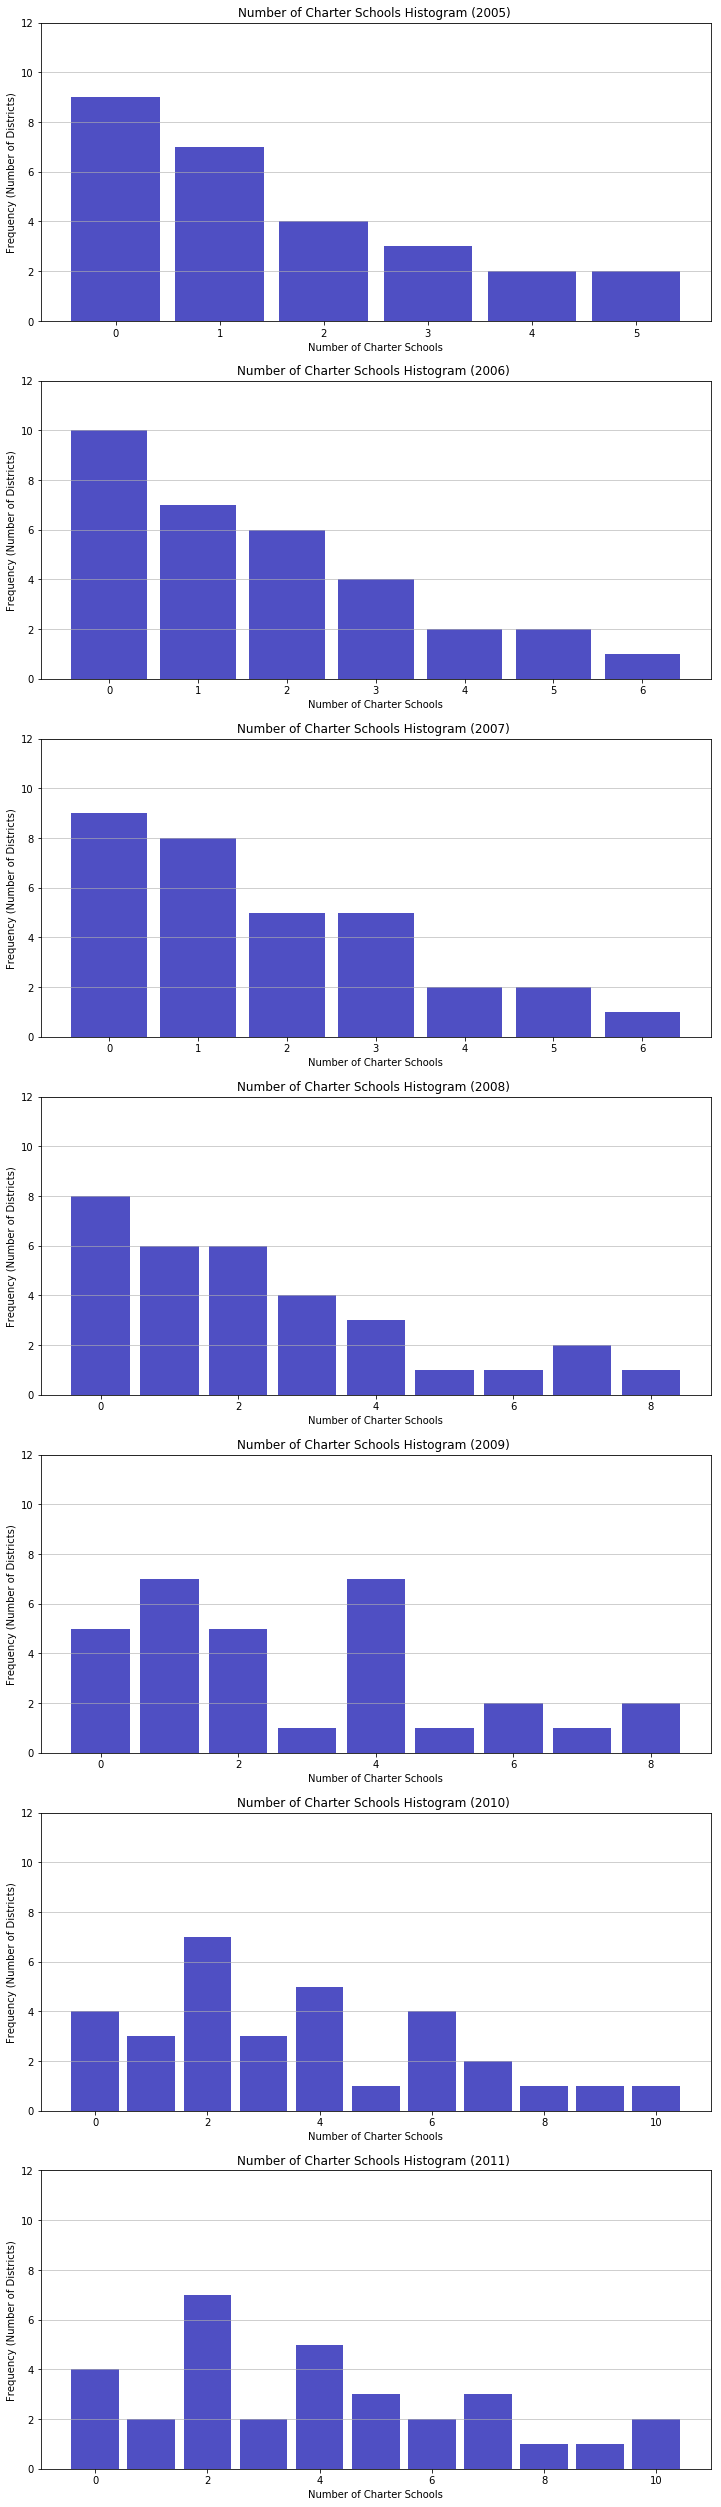

In [48]:
plt.figure(figsize = (12,45))
for year in range(2005, 2012):
    plt.subplot(7, 1, year - 2004)
    tmp = df_final[df_final['year'] == year].num_charters
    bins = np.arange(tmp.min(), tmp.max()+2, 1) - 0.5
    
    plt.hist(x=tmp, bins = bins , color='#0504aa', rwidth = 0.85, alpha = 0.7)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Number of Charter Schools')
    plt.ylabel('Frequency (Number of Districts)')
    plt.title('Number of Charter Schools Histogram (%d) ' %year)
    plt.ylim([0,12]);

Note how in the first histogram (the one representing school districts from 2005), the peak of the distribtion is shifted entirely to the left, at 0. However, as the years progress, this peak starts to become less pronouced, and by 2009 starts to shift to the rights. In the histogram representing schools from 2011, the peak of the distribution is now located at 2 charter schools, and the distribution itself is much more even looking. This smoothing of the distribution is the first indiction that the number of charter schools across all districts is most likely increasing. 

_______________

In addition to the histograms seen above, the figure seen below provides further evidence that the number of charter schools in each district has done nothing but increase. The following cell includes code used to create a line plot showing the number of charter schools as a function of time for every 3rd school district. Not every school district was included for the purpose of clarity. 

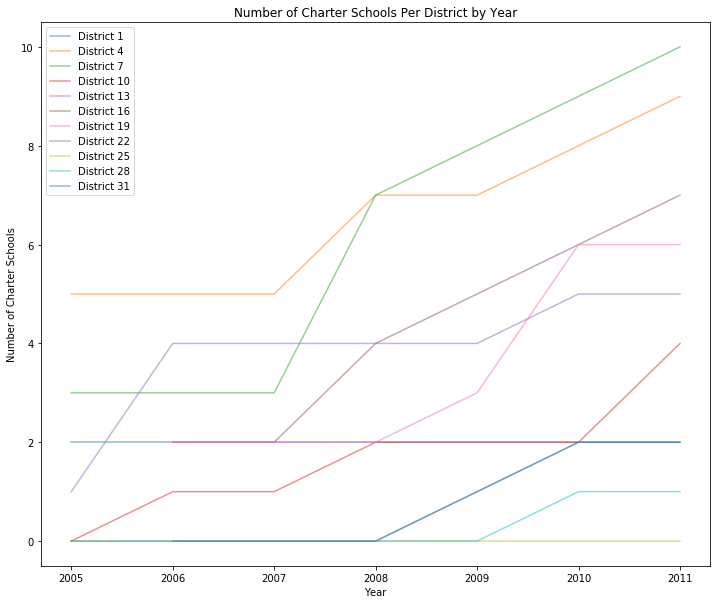

In [49]:
plt.figure(figsize = (12, 10))
plt.title('Number of Charter Schools Per District by Year')

plt.ylabel('Number of Charter Schools')
plt.xlabel('Year')
for district in range(1, 33, 3):
    tmp = df_final[df_final['district'] == district]
    plt.plot(tmp['year'], tmp['num_charters'], alpha = 0.5, label = 'District %d' %district)
    plt.legend()

As is made clear by the figure above, every school district represented has either the number of charter schools stay the same or increase. Because the above picture only shows every 3rd school district, the following cell makes sure that this is the case for all of them:

In [50]:
num_charters_2005 = df_final[df_final['year'] == 2005].num_charters.sum()
num_charters_2011 = df_final[df_final['year'] == 2011].num_charters.sum()

counter = 0
for district in range(1, 33):
    tmp = df_final[df_final['district'] == district]
    max_year = tmp[tmp['year'] == tmp.year.max()]
    min_year = tmp[tmp['year'] == tmp.year.min()]
    if max_year['num_charters'].values[0] < min_year['num_charters'].values[0]:
        counter += 1

num_charters_2005 = df_final[df_final['year'] == 2005].num_charters.sum()
num_charters_2011 = df_final[df_final['year'] == 2011].num_charters.sum()


print('Total number of charter schools in 2005: {}'.format(num_charters_2005))
print('Total number of charter schools in 2011: {}'.format(num_charters_2011))
print('Number of school districts that had less charter schools in 2011 compared to 2005: {}'.format(counter))


Total number of charter schools in 2005: 42
Total number of charter schools in 2011: 127
Number of school districts that had less charter schools in 2011 compared to 2005: 0


The cell above also provides code to determine the total number of charter schools in both 2005 and 2011. As is clear from the information printed above, charter schools are clearly beginning to become more prevalent in the NYC school system. This finding is a satifying result, as it gives validity to the relevance of the question being explored.

## 3.3: Most Common Ratings Given to NYC Public Schools

The second finding that came as a result of the preliminary, exploratory data analysis was that a large majority of the quality review ratings given to NYC public schools are positve (either `WD` well-developed or `P` proficient). However, despite this majority, the percentage of the total number of ratings that were positive has decreased over the years from 2005-2011. 

The cell below includes code that creates histograms of the most common rating given to schools in a district. As in the previous subsection, seven histograms are included representing each of the seven years between 2005 and 2011. These histograms are the first piece of evidence to support the claim that the overwhelming majoirty of quality review ratings given to NYC public schools are positive.

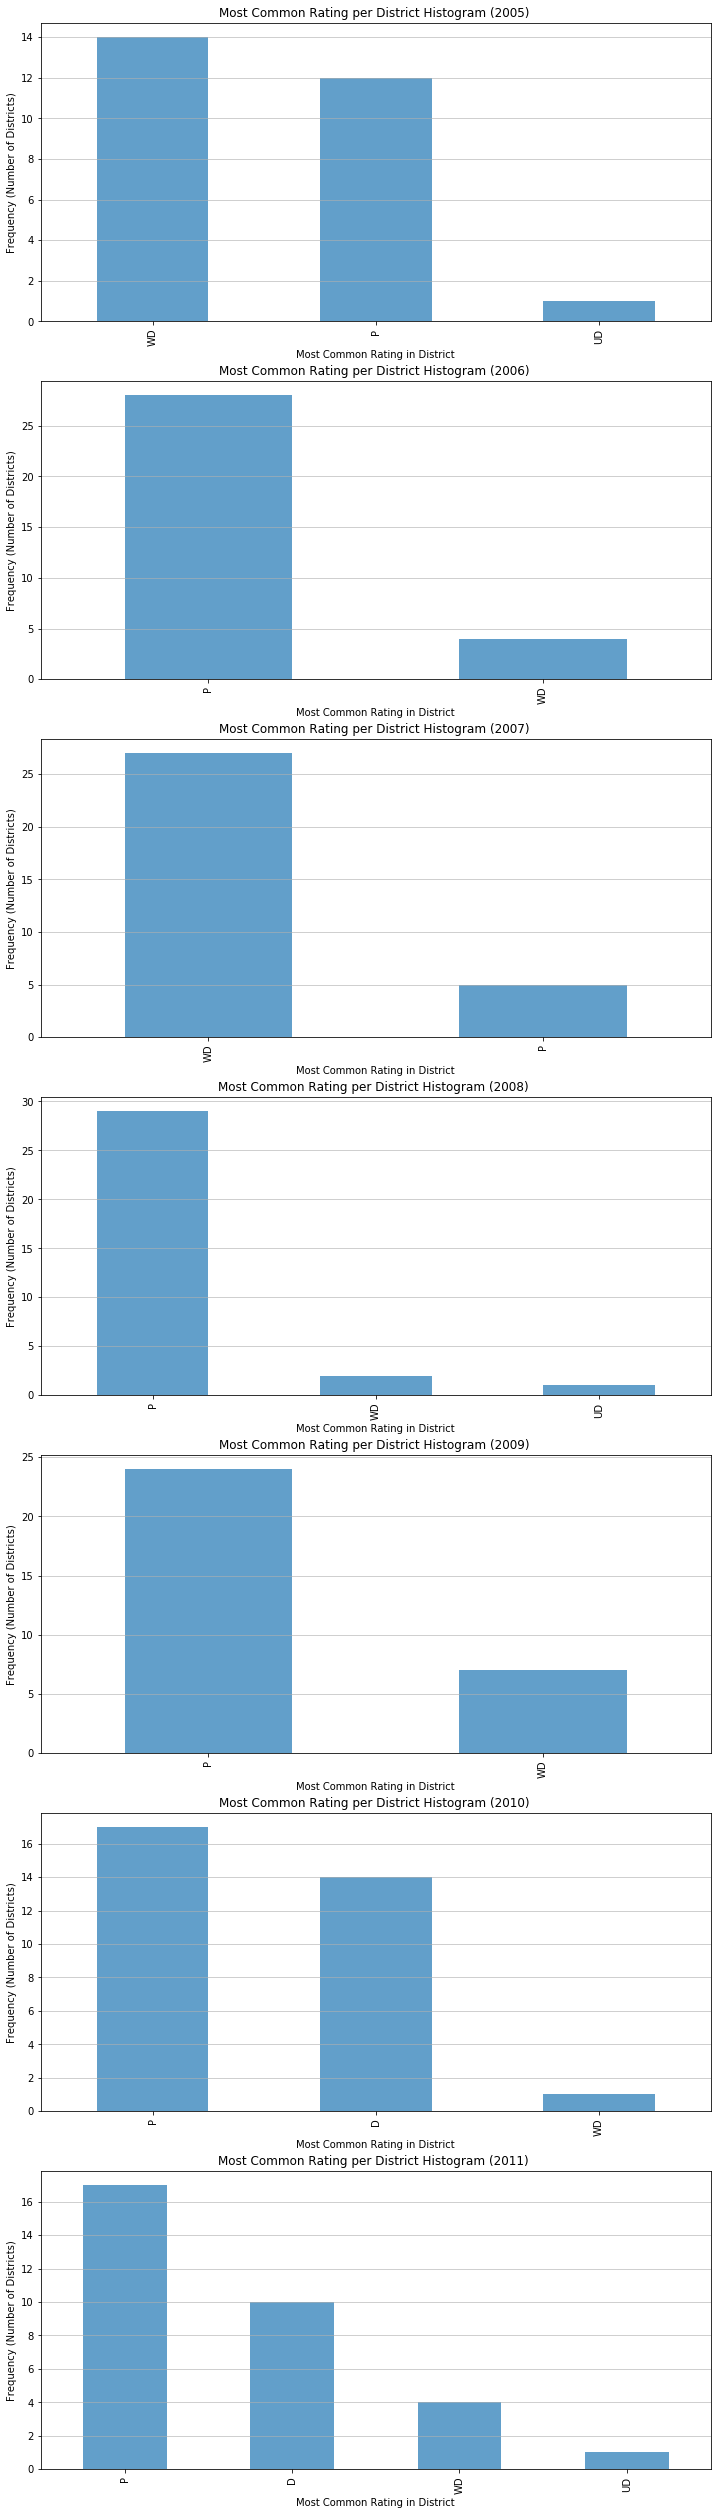

In [51]:
plt.figure(figsize = (12,45))
for year in range(2005, 2012):
    plt.subplot(7, 1, year - 2004)
    tmp = df_final[df_final['year'] == year].most_common_rating
    tmp.value_counts().plot.bar(alpha = 0.7)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Most Common Rating in District')
    plt.ylabel('Frequency (Number of Districts)')
    plt.title('Most Common Rating per District Histogram (%d) ' %year)

A quick review of the histograms above results in some interesting findings, which are listed below:
<ol>
    <li> In all the histograms, the highest frequency most common rating is one of the positive rankings (<code>P</code> or <code>WD</code>).</li>
    <li> In all of the histograms, either one or both of negative ratings (<code>UD</code> or <code>D</code>) has a frequency of 0.
    <li> Only in the years 2008 and 2009 is there a significant occurance of a negative most common rating (<code>D</code>).
</ol>

The more obvious of conclusions that can be drawn from these findings is that quality review ratings, on average, tend to be pretty good. Despite this, given the resuls seen in the 2008 and 2009 histograms, it might be the case that the number of positive ratings begin to decline as time goes on.

The cell below uses the <b>mcr_numerical</b> column of the `df_final` dataframe in order to determine the average  most common rating across all school districts as a function of time. 

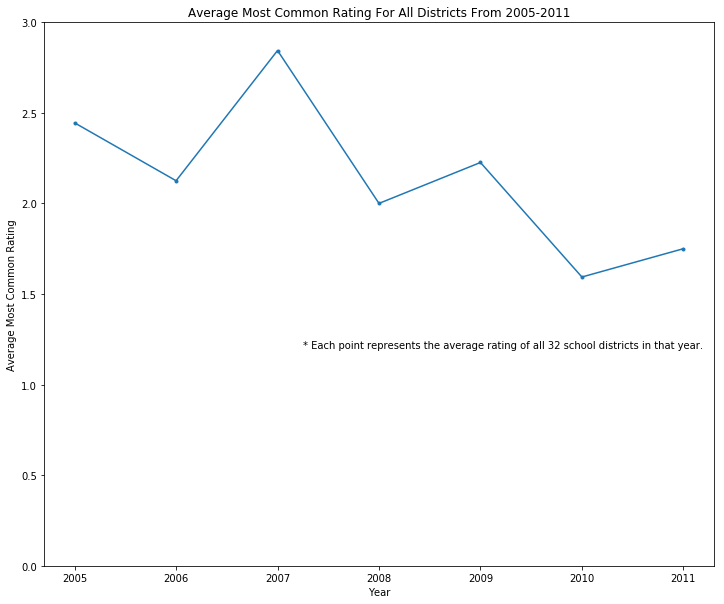

In [52]:
plt.figure(figsize = (12, 10))
plt.title('Average Most Common Rating For All Districts From 2005-2011')
plt.ylabel('Average Most Common Rating')
plt.xlabel('Year')
plt.ylim([0,3])

plt.plot(range(df_final['year'].min(), df_final['year'].max()+1), \
         df_final.groupby(['year']).mean()['mcr_ordinal'], \
         marker=".");
plt.text(2007.25, 1.2, "* Each point represents the average rating of all 32 school districts in that year.");


While the graph above does show some flucuations, it is clear that the overall trend in seems to be that the average most common rating for all school districts has decreased over the year. The following cells provide a brief linear regression analysis for these results, along with the pearson correlation coeficient: 

In [53]:
x = np.array(range(df_final['year'].min(), df_final['year'].max()+1))
y = df_final.groupby(['year']).mean()['mcr_ordinal'].values
a, b = np.polyfit(x, y, 1)
r = pearsonr(x, y)[0]

print('Linear Regression Results: \n')
print('a = {}'.format(a))
print('b = {}'.format(b))
print('r = {}'.format(r))

Linear Regression Results: 

a = -0.13442060291859825
b = 272.0569636456964
r = -0.6890367846687387


Note that the linear results shown above correspond to a linear model of the following form: <br>
<center>
$\hat{Y} = aX + b$
</center>

These results (especially a relatively low $r$ value of $\approx$ -0.65) indicate that there is indeed a quantifiable correlation between the average most common rating in a district and time. The cell below checks to see if this correlation is statistically significant, and also gives the 95% confidence interval for the ($a$) value seen above. Each was calculated via the use of bootstrap replicates.

In [54]:
a_b_replicates = regression_replicates(replicates_size, x, y, 1)
a_replicates = a_b_replicates[:,0]
b_replicates = a_b_replicates[:,1]
p_value_r = r_value_p_calc(replicates_size, x, y)

print('a (95% confidence interval): ', np.percentile(a_replicates, [2.5, 97.5]))
print('r (p value): {}'.format(p_value_r))

a (95% confidence interval):  [-0.30749273 -0.03058814]
r (p value): 0.0423


According to the results above, the $p$ calculated on the correlation coefficient is almost nearly below the threshold of significance ($\alpha =$ 0.05). In addition, we can say with 95% confidence that the coefficient determining the relationship between these two variables is a negative value approximately -0.29 and -0.03. In other words, we can say with a high degree of confidence that the decrease in the average most common public school rating over the years is statistically significant. The figure created by the code below simply summarizes these findings into a graph.

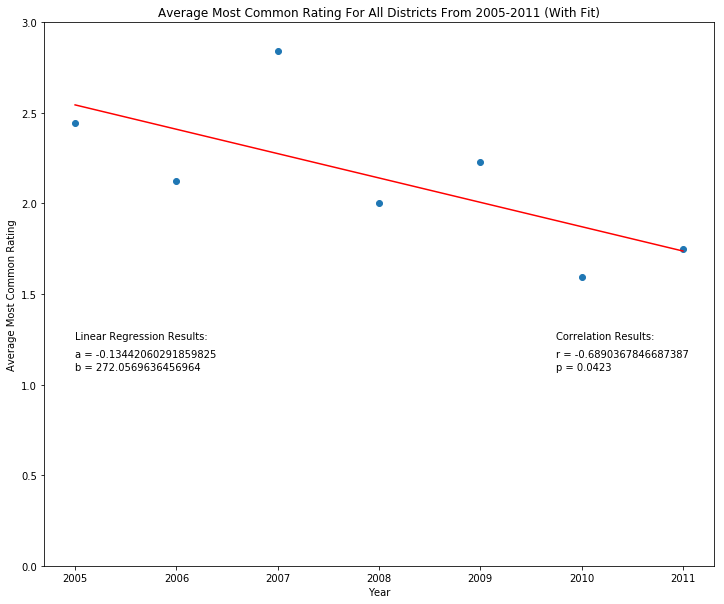

In [55]:
plt.figure(figsize = (12, 10))
plt.scatter(x, y)
plt.plot(x, a*x+b, color='red')
plt.title('Average Most Common Rating For All Districts From 2005-2011 (With Fit)')
plt.ylabel('Average Most Common Rating')
plt.xlabel('Year')
plt.ylim([0,3])
plt.text(2005, 1.25, 'Linear Regression Results:');
plt.text(2005, 1.15, 'a = {}'.format(a));
plt.text(2005, 1.08, 'b = {}'.format(b));
plt.text(2009.75, 1.25, 'Correlation Results:');
plt.text(2009.75, 1.15, 'r = {}'.format(r));
plt.text(2009.75, 1.08, 'p = {}'.format(p_value_r));

These results are exciting because now in addition to seeing an increase in the number of charter schools over the years, we also see hints that the public school ratings over that same time period have started to decrease in quality. In other words, it might be the case that the two variables in question maintain a negative correlation. 

## 3.4: Correlation Between Number of Charters and Most Common Public School Rating

At this point, the logical next step is to examine the correlation between the two variables of interest in this project: the number of charter schools in a distrct, and the most common public school rating in that same district. The code in the cell below produces a scatterplot allowing us to do just that:

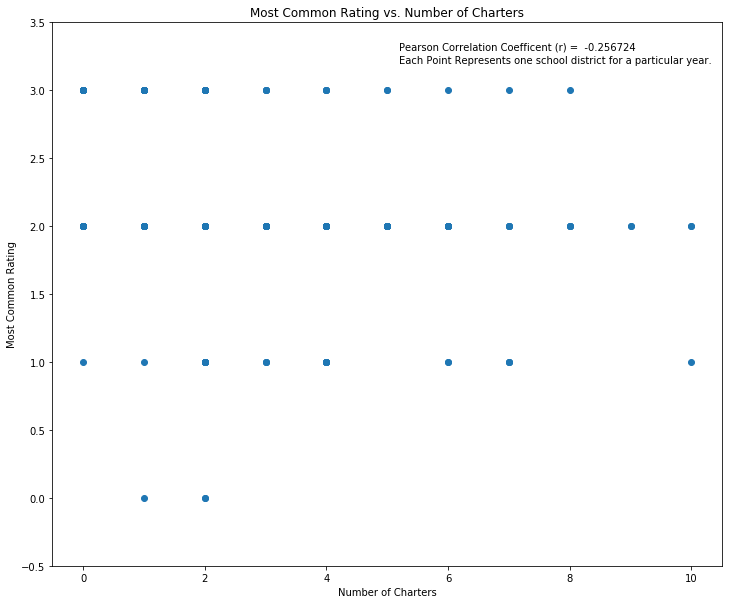

In [56]:
plt.figure(figsize = (12, 10))
plt.scatter(df_final.num_charters, df_final.mcr_ordinal)
plt.xlabel('Number of Charters')
plt.title('Most Common Rating vs. Number of Charters')
plt.ylabel('Most Common Rating')
plt.ylim([-0.5,3.5])
r = pearsonr(df_final.num_charters, df_final.mcr_ordinal)[0]
plt.text(5.2, 3.3, 'Pearson Correlation Coefficent (r) =  %f' %r);
plt.text(5.2, 3.2, 'Each Point Represents one school district for a particular year.');

Upon first inspection, the graph below looks quite awkward due to the fact that the most common rating in a district can take only four different possible values, and that many dots are stacked on top of each other. However, despite this awkward looking graph, the calculated $r$ value  of approximately -0.22 is low enough to make the claim that their exists a slight negative correlation between the two variables. The cell below determines the $p$ value for this correlation coefficient:

In [57]:
p = r_value_p_calc(replicates_size, df_final.num_charters, df_final.mcr_ordinal)
print('Correlation Results:\n')
print('r = {}'.format(r))
print('p = {}'.format(p))

Correlation Results:

r = -0.25672434247677056
p = 0.0001


According to the results above, the slight correlation that exists between the two variables is statistically significant! This bodes well for the prospects of more in-depth analysis.

## 3.5: Correlation Between Number of Charters and Average Public School Rating

Despite the facts that the previous subsection produced results indicating that further analysis might provide fruitful results, it was difficult to note the correlation between the number of charters and the most common rating due to the fact that the most common rating in a district can only be one of four values. In addition, as shown in section 3.3, the most common ratings in each district are overwhelmingly positive. For the reason, it might be the case that aggregating by the average rating in a district might provide clearer results as opposed to aggregating by the most common rating in a district. The code in the cell below creates a new column in the `df_final` dataframe named <b>avg_rating</b> which aggregates the quality review ratings by the average rating in a district each year:

In [58]:
tmp = public_school_ratings.copy()
tmp['overall_rating'] = tmp['overall_rating'].map(make_numerical_ratings)
tmp = tmp.groupby(['district', 'school_year']).mean()
tmp = tmp.reset_index().drop('number', axis = 1)
tmp.columns = ['district', 'year', 'avg_rating']
df_final['avg_rating'] = tmp['avg_rating']
df_final.head()

,district,year,num_charters,num_public,pub_chtr_diff,num_ratings,most_common_rating,mcr_binary,mcr_ordinal,avg_rating
0,1,2005,2,16,14,1,WD,1,3,3.000000
1,1,2006,2,16,14,12,P,1,2,1.833333
2,1,2007,2,16,14,13,P,1,2,2.153846
3,1,2008,2,16,14,3,P,1,2,1.333333
4,1,2009,2,16,14,8,WD,1,3,2.250000


As can be seen in the header printed above, the `df_final` dataframe now contains the <b>avg_rating</b> column, containing the average rating from all schools in a district each year calculated using the ordinal scale first described in section 3.1.2.<br>

Let's now examine the correlation between the number of charter schools and this new version of our dependent variable:

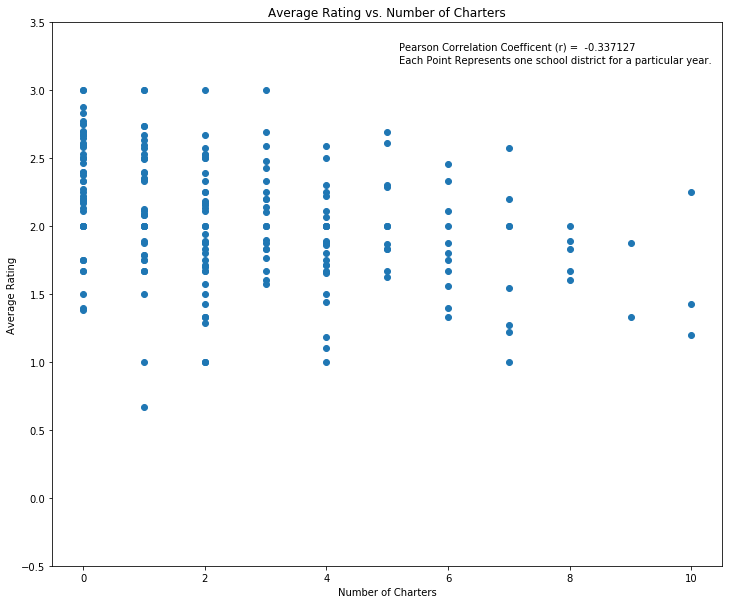

In [59]:
plt.figure(figsize = (12, 10))
plt.scatter(df_final.num_charters, df_final.avg_rating)
plt.xlabel('Number of Charters')
plt.title('Average Rating vs. Number of Charters')
plt.ylabel('Average Rating')
plt.ylim([-0.5, 3.5])
r = pearsonr(df_final.num_charters, df_final.avg_rating)[0]
plt.text(5.2, 3.3, 'Pearson Correlation Coefficent (r) =  %f' %r);
plt.text(5.2, 3.2, 'Each Point Represents one school district for a particular year.');

The graph below makes the relationship between the frequency of charter schools and public school performance a little clearer. By aggregating the quality review ratings in a district by their average as opposed to their mode, we get a clearer picture of the correlation between them. Quantitatively, the $r$ value has also become more pronounced and reaches a value of approximately -0.34 (still not remarkable, but defintiely more impressive than the -0.22 value seen in section 3.4). The cell below checks the $p$ value for this correlation. 

In [60]:
p = r_value_p_calc(replicates_size, df_final.num_charters, df_final.avg_rating)
print('Correlation Results:\n')
print('r = {}'.format(r))
print('p = {}'.format(p))

Correlation Results:

r = -0.3371272214540595
p = 0.0


As can be seen in the printout above, the $p$ value in this case has actually reached 0, meaning that none of the $r$ bootstrap replicates reached a value that was less than or equal to -0.33.  

## 3.6: Summary of Exploratory Data Analysis

The exploratory data analysis that was performed in this section produced three results that hint at the possibility for a genuine connection between the number of charter schools in a district and public school performance in that same district. These are summarized below:
<ol>
    <li><b>The number of charter schools in a has either stayed the same or increased for all school districts from the years 2005-2011.</b></li>
    <li><b>Public school quality review ratings tend to be positve, but on average seem decline over the course of the years 2005-2011.</b></li>
    <li><b>There exists a small, but statistically significant negative correlation between the number of charter schools in a district and the most common public school rating given in that same distirct. In additon, when looking instead at the average public school rating in a district, this correlation becomes more significant.</b></li>
</ol>

The results provided in this section are enough to prove that the question attempted to be answered is relevant, and that it warrants further analysis. 

# Section 4: In-Depth Analysis and Predictive Modeling

The work done in this section aims to prove the extent to which the correlation seen between the number of charter schools in a district and public school performance in that same district can be used to create effective predictive models. In doing so, we can further analyze the relationship between the two and make a better determination as to the genuine nature of their apparent connection. Three different models are created in this section: a linear regression model, a logistic regression model, and a k-nearest neighbors model. 

## 4.1: Linear Model Analysis




### 4.1.1: OLS Model Summaries

In [61]:
m = ols('avg_rating ~ num_charters', df_final).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     27.70
Date:                Thu, 04 Jul 2019   Prob (F-statistic):           3.41e-07
Time:                        01:23:24   Log-Likelihood:                -127.77
No. Observations:                 218   AIC:                             259.5
Df Residuals:                     216   BIC:                             266.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.2095      0.043     50.875   

In [62]:
m = ols('avg_rating ~ pub_chtr_diff', df_final).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7105
Date:                Thu, 04 Jul 2019   Prob (F-statistic):              0.400
Time:                        01:23:24   Log-Likelihood:                -140.56
No. Observations:                 218   AIC:                             285.1
Df Residuals:                     216   BIC:                             291.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.9922      0.067     29.712

In [63]:
m = ols('avg_rating ~ pub_chtr_diff + num_charters', df_final).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     13.78
Date:                Thu, 04 Jul 2019   Prob (F-statistic):           2.33e-06
Time:                        01:23:24   Log-Likelihood:                -127.77
No. Observations:                 218   AIC:                             261.5
Df Residuals:                     215   BIC:                             271.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.2088      0.076     29.081

In [64]:
m = ols('mcr_ordinal ~ num_charters', df_final).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            mcr_ordinal   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     15.24
Date:                Thu, 04 Jul 2019   Prob (F-statistic):           0.000127
Time:                        01:23:24   Log-Likelihood:                -206.84
No. Observations:                 218   AIC:                             417.7
Df Residuals:                     216   BIC:                             424.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.3114      0.062     37.030   

In [65]:
m = ols('avg_rating ~ num_charters + pub_chtr_diff + num_charters*pub_chtr_diff', df_final).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     9.439
Date:                Thu, 04 Jul 2019   Prob (F-statistic):           6.95e-06
Time:                        01:23:24   Log-Likelihood:                -127.37
No. Observations:                 218   AIC:                             262.7
Df Residuals:                     214   BIC:                             276.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 4.1.2: Building A Linear Regression Model

In [66]:
X = df_final.num_charters.values.reshape(-1, 1)
y = df_final.avg_rating.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rs, stratify = X)

In [67]:
lin_reg_model = LinearRegression()
cv_scores = cross_val_score(lin_reg_model, X, y, cv = 4)
print('Median R^2 value: {}'.format(np.median(cv_scores)))

Median R^2 value: 0.10465509910904447


In [68]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
predictions = lin_reg_model.predict(X_test)
coefficient = lin_reg_model.coef_[0][0]
intercept = lin_reg_model.intercept_[0]
print("R^2: {}".format(lin_reg_model.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error: {}".format(rmse))
print('Coefficient: {}'.format(coefficient))
print('Intercept: {}'.format(intercept))

R^2: 0.05162429953080294
Root Mean Squared Error: 0.39110202394050214
Coefficient: -0.0713352955147082
Intercept: 2.207104102216128


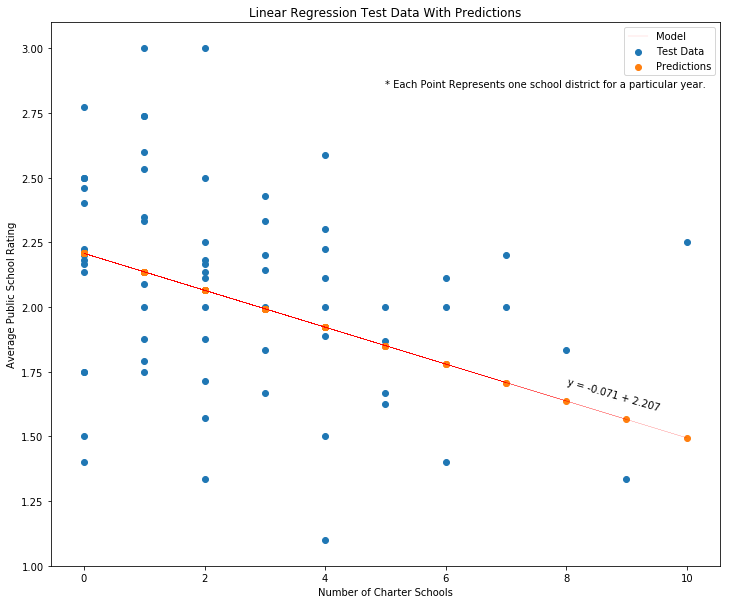

In [69]:
plt.figure(figsize = (12, 10))
plt.scatter(X_test, y_test, label = 'Test Data')
plt.scatter(X_test, predictions, label = 'Predictions')
plt.plot(X_test, (X_test * coefficient) + intercept, color = 'red', linewidth = 0.1, label = 'Model')
plt.legend()
plt.xlabel('Number of Charter Schools');
plt.ylabel('Average Public School Rating');
plt.title('Linear Regression Test Data With Predictions')
plt.text(5, 2.85, '* Each Point Represents one school district for a particular year.');
plt.text(8, 1.7, 'y = %0.3f + %1.3f' %(coefficient, intercept), rotation = -16);

In [70]:
all_predictions = (X * coefficient) + intercept
residuals = all_predictions - y
std_residuals = (residuals - np.mean(residuals))/ np.std(residuals)

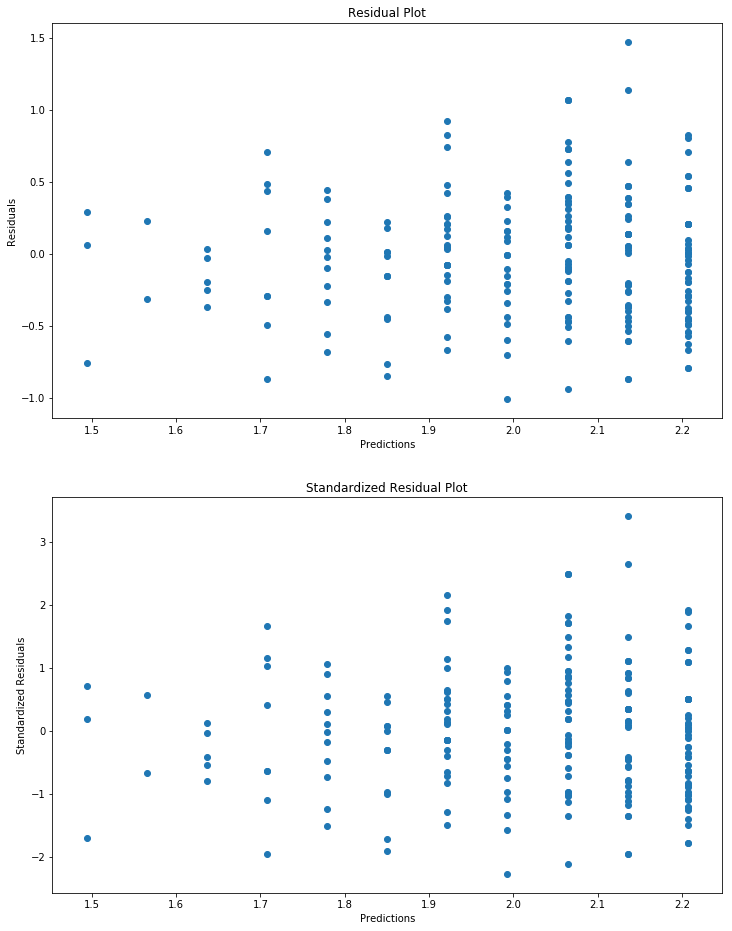

In [71]:
plt.figure(figsize = (12, 16))
plt.subplot(2, 1, 1)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.scatter(all_predictions, residuals)
plt.subplot(2, 1, 2)
plt.xlabel('Predictions')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residual Plot')
plt.scatter(all_predictions, std_residuals);

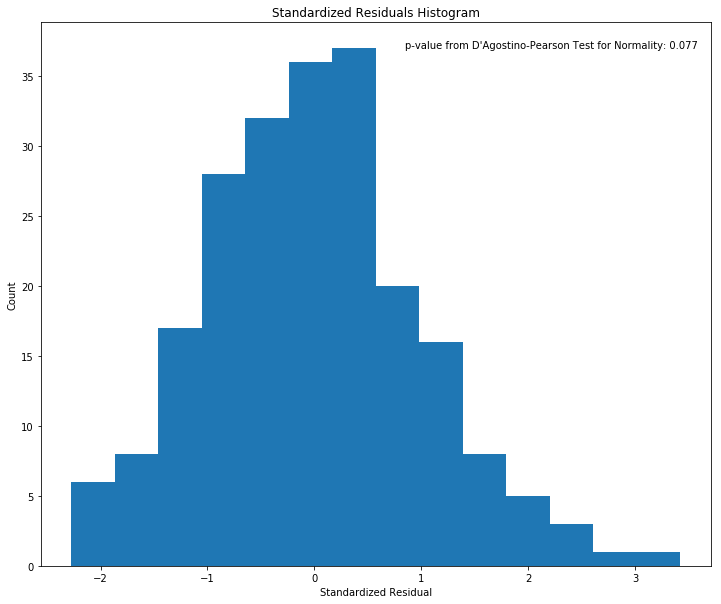

In [72]:
plt.figure(figsize = (12, 10))
num_bins = int(np.sqrt(len(residuals)))
plt.hist(std_residuals, num_bins)
plt.xlabel('Standardized Residual')
plt.ylabel('Count')
plt.title('Standardized Residuals Histogram')
_, DP_pval = stats.normaltest(std_residuals) # D'Agostino-Pearson Test
plt.text(0.85, 37, 'p-value from D\'Agostino-Pearson Test for Normality: %0.3f' %DP_pval[0]);

## 4.2: Logistic Regression Analysis

In [73]:
m = Logit(df_final.mcr_binary, df_final.num_charters).fit()
print(m.summary())

Optimization terminated successfully.
         Current function value: 0.557474
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             mcr_binary   No. Observations:                  218
Model:                          Logit   Df Residuals:                      217
Method:                           MLE   Df Model:                            0
Date:                Thu, 04 Jul 2019   Pseudo R-squ.:                 -0.4885
Time:                        01:23:25   Log-Likelihood:                -121.53
converged:                       True   LL-Null:                       -81.648
                                        LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
num_charters     0.3840      0.063      6.133      0.000       0.261       0.507


## 4.3: K-Nearest Neighbor Analysis 

In [74]:
X = df_final.num_charters.values.reshape(-1, 1)
y = df_final.mcr_ordinal.values.reshape(-1, )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = rs, stratify = y)

In [75]:
k_neighbors_model = KNeighborsClassifier(n_neighbors = 1)
k_neighbors_model.fit(X_train, y_train)
predictions = k_neighbors_model.predict(X_test)
print("Accuracy Score: {}".format(k_neighbors_model.score(X_test, y_test)))

Accuracy Score: 0.3787878787878788


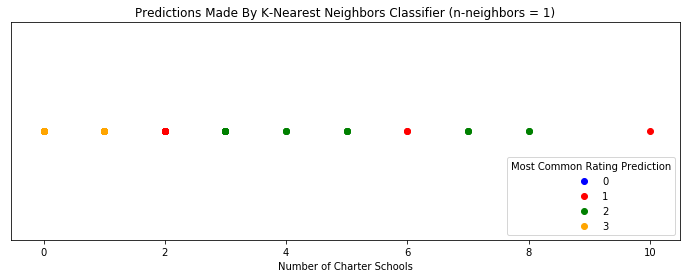

In [76]:
prediction_df = pd.DataFrame({'x': X_test.reshape(-1, ), 'y': predictions})
fig, ax = plt.subplots(figsize =(12, 4))
for i in range(0, 4):
    subset = prediction_df[prediction_df['y'] == i]
    if i == 0:
        color = 'blue'
    elif i == 1: 
        color = 'red'
    elif i == 2:
        color = 'green'
    else:
        color = 'orange'
    plt.scatter(subset.x, np.zeros(len(subset.x)), color = color, label = i)
plt.legend(title = 'Most Common Rating Prediction',loc = 'lower right')
plt.xlabel('Number of Charter Schools')
plt.title('Predictions Made By K-Nearest Neighbors Classifier (n-neighbors = 1)')
ax.set_yticks([]);

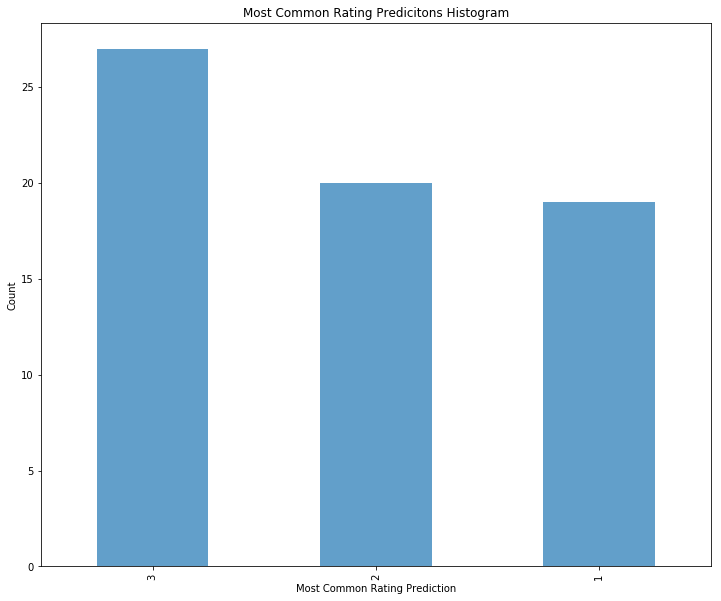

In [77]:
plt.figure(figsize = (12, 10))
prediction_df['y'].value_counts().plot.bar(alpha = 0.7)
plt.xlabel('Most Common Rating Prediction')
plt.ylabel('Count')
plt.title('Most Common Rating Predicitons Histogram');

In [78]:
X = df_final[['num_charters', 'pub_chtr_diff']].values
y = df_final.mcr_ordinal.values.reshape(-1, )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rs, stratify = y)

In [79]:
k_neighbors_model = KNeighborsClassifier(n_neighbors = 1)
k_neighbors_model.fit(X_train, y_train)
predictions = k_neighbors_model.predict(X_test)
print("Accuracy Score: {}".format(k_neighbors_model.score(X_test, y_test)))

Accuracy Score: 0.5606060606060606


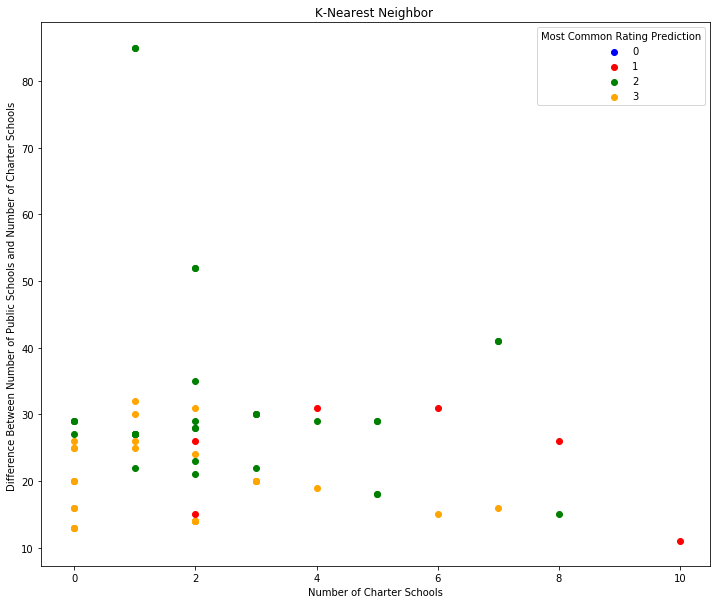

In [80]:
df_predictions = pd.DataFrame(X_test)
df_predictions['y'] = predictions
df_predictions.columns = ['x1', 'x2', 'y']
plt.figure(figsize = (12, 10))
for i in range(0, 4):
    subset = df_predictions[df_predictions['y'] == i]
    if i == 0:
        color = 'blue'
    elif i == 1: 
        color = 'red'
    elif i == 2:
        color = 'green'
    else:
        color = 'orange'
    plt.scatter(subset.x1, subset.x2, color = color, label = i)
    plt.legend(title = 'Most Common Rating Prediction')
    plt.xlabel('Number of Charter Schools')
    plt.ylabel('Difference Between Number of Public Schools and Number of Charter Schools ')
    plt.title('K-Nearest Neighbor ')

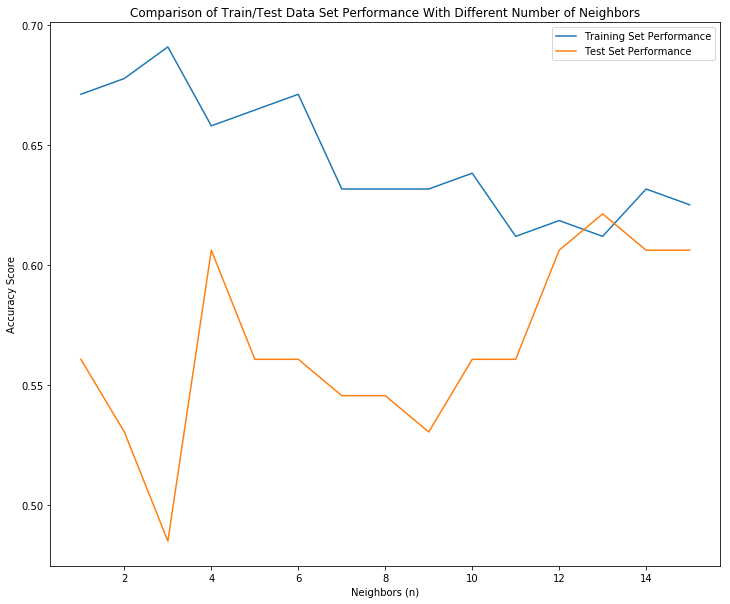

In [81]:
plt.figure(figsize = (12, 10))
max_n = 15
neighbors = np.arange(1, max_n+1)
train_scores = np.empty(len(neighbors))
test_scores = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn_tmp = KNeighborsClassifier(n_neighbors = k)
    knn_tmp.fit(X_train, y_train)
    train_scores[i] = knn_tmp.score(X_train, y_train)
    test_scores[i] = knn_tmp.score(X_test, y_test)

plt.plot(neighbors, train_scores, label = 'Training Set Performance')
plt.plot(neighbors, test_scores, label = 'Test Set Performance')
plt.legend(loc='upper right')
plt.xlabel('Neighbors (n)')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Train/Test Data Set Performance With Different Number of Neighbors');
    

In [82]:
k_neighbors_model = KNeighborsClassifier(n_neighbors = 2)
k_neighbors_model.fit(X_train, y_train)
predictions = k_neighbors_model.predict(X_test)
print("Accuracy Score: {}".format(k_neighbors_model.score(X_test, y_test)))

Accuracy Score: 0.5303030303030303


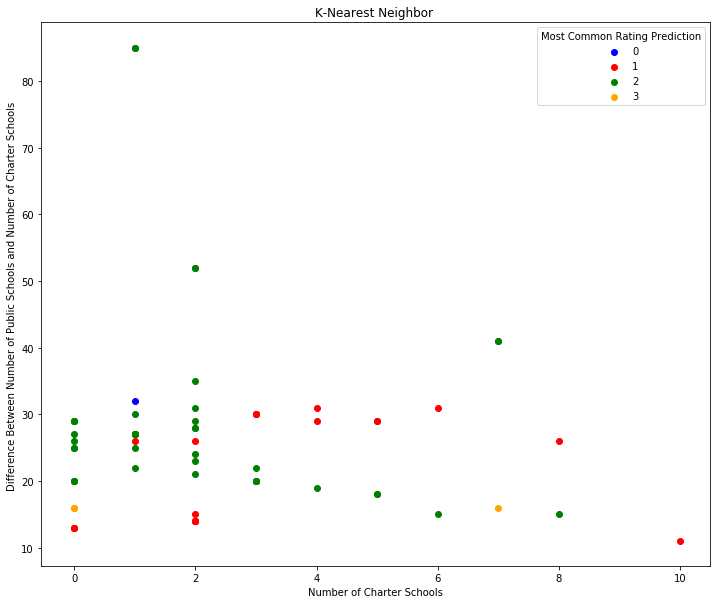

In [83]:
df_predictions = pd.DataFrame(X_test)
df_predictions['y'] = predictions
df_predictions.columns = ['x1', 'x2', 'y']
plt.figure(figsize = (12, 10))
for i in range(0, 4):
    subset = df_predictions[df_predictions['y'] == i]
    if i == 0:
        color = 'blue'
    elif i == 1: 
        color = 'red'
    elif i == 2:
        color = 'green'
    else:
        color = 'orange'
    plt.scatter(subset.x1, subset.x2, color = color, label = i)
    plt.legend(title = 'Most Common Rating Prediction')
    plt.xlabel('Number of Charter Schools')
    plt.ylabel('Difference Between Number of Public Schools and Number of Charter Schools ')
    plt.title('K-Nearest Neighbor ')

----------------------------------------

In [84]:
row_limit = '10000'
cols = 'BN,school_year,overall_rating'
SoQL_query = '&$select=' + cols
r = rq.get('https://data.cityofnewyork.us/resource/rwa3-b3wr.json?$limit=' + row_limit)
public_schools =  pd.DataFrame(r.json())
public_schools.head()

,_progress_report_grade_1,_progress_report_grade_2,_progress_report_grade_3,_progress_report_grade_4,bn,progress_report_type,school_name
0,C,A,B,B,K001,EMS,P.S. 001 The Bergen
1,B,A,A,B,K002,EMS,M.S. 002
2,C,A,A,C,K003,EMS,P.S. 003 The Bedford Village
3,B,A,A,F,K005,EMS,P.S. 005 Dr. Ronald Mcnair
4,B,A,A,B,K006,EMS,P.S. 006


In [85]:
public_schools[['borough', 'number']] = public_schools.apply(  
    lambda row: pd.Series(separate_dbn_or_bn(row['bn'])), axis = 1)
public_schools.head()

,_progress_report_grade_1,_progress_report_grade_2,_progress_report_grade_3,_progress_report_grade_4,bn,progress_report_type,school_name,borough,number
0,C,A,B,B,K001,EMS,P.S. 001 The Bergen,Brooklyn,1
1,B,A,A,B,K002,EMS,M.S. 002,Brooklyn,2
2,C,A,A,C,K003,EMS,P.S. 003 The Bedford Village,Brooklyn,3
3,B,A,A,F,K005,EMS,P.S. 005 Dr. Ronald Mcnair,Brooklyn,5
4,B,A,A,B,K006,EMS,P.S. 006,Brooklyn,6


In [86]:
public_schools = public_schools.drop(columns = ['progress_report_type', 'school_name'])
public_schools.head()

,_progress_report_grade_1,_progress_report_grade_2,_progress_report_grade_3,_progress_report_grade_4,bn,borough,number
0,C,A,B,B,K001,Brooklyn,1
1,B,A,A,B,K002,Brooklyn,2
2,C,A,A,C,K003,Brooklyn,3
3,B,A,A,F,K005,Brooklyn,5
4,B,A,A,B,K006,Brooklyn,6


In [87]:
public_schools.columns = ['2009_grade', '2008_grade', '2007_grade', '2006_grade', 'bn', 'borough', 'number']
public_schools.head()

,2009_grade,2008_grade,2007_grade,2006_grade,bn,borough,number
0,C,A,B,B,K001,Brooklyn,1
1,B,A,A,B,K002,Brooklyn,2
2,C,A,A,C,K003,Brooklyn,3
3,B,A,A,F,K005,Brooklyn,5
4,B,A,A,B,K006,Brooklyn,6
